# Image-Based Structural Analysis
### Code created and maintained by Justin David Q. SAN JUAN, <br>email: jdqsj1997@yahoo.com, <br> personal website: justinsj.weebly.com

#### This code focuses in the segmentation and classification processes (except reconstruction) of the complete project pipeline as described below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/process-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

# Import Dependencies
#### Dependencies:
numpy: for handling data types (mostly handled as numpy arrays)<br>
Sequential (from keras.models): for CNN setup<br>
random: for pseudo-random shuffling of data<br>
cv2: for raw RBG image import and transformation to grayscale<br>
time: for measuring time elapsed per function<br>
##### Custom Classes:
ComponentSegmentation: for proposing regions of interest (RoI's)<br>
ExtractionPreprocessing: for trimming, noise removal, and resizing of image<br>
ComponentClassifierTraining: for loading the CNN model, training data, and training the model<br>
ComponentClassifierPredict: for using the CNN model to predict the class of preprocessed extractions<br>
ExtractionLabelling: for labelling ground truth bounding boxes and classes in problem images<br>
TestingClass: for testing the accuracy of a CNN model on the problem images<br>
<br>
print_image_bw is used to print a simple 2-D array<br>
gc: for clearing up space after acquiring data from larger datasets

In [1]:
from __future__ import print_function
import numpy as np

from keras.models import Sequential

import random

import cv2
import time

from component_segmentation import ComponentSegmentation
from extraction_preprocessing import ExtractionPreprocessing
from component_classifier_training import ComponentClassifierTraining
from component_classifier_predict import ComponentClassifierPredict
from extraction_labelling import ExtractionLabelling
from testing_class import TestingClass
from helper_functions import print_image_bw
from helper_functions import plot_model_results_and_save
from helper_functions import print_time_string, store_time

import gc
gc.enable()

print('Done Importing...')

Using TensorFlow backend.


Done Importing...


# Hyper-parameters
#### Selective Search Parameters:
scale_input<br>
sigma_input<br>
min_size_input<br>
#### Noise Reduction Parameters:
min_shape: for minimum number of black pixels in bounding box<br>
min_height: for minimum height of bounding box<br>
min_width: for minimum width of bounding box<br>
<br>
buffer_zone: for expanding bounding box all directions<br>
min_area: for minimum area of bounding box<br>
min_black: for minimum number of black pixels in bounding box<br>
min_black_ratio: for minimum ratio of black pixels to the bounding box area<br>
#### Overlap Parameters:
overlap_repeats: for number of iterations for merging algorithm to be applied<br>
overlap_threshold: threshold of area overlap over union area for merging to be applied<br>
#### Removing Unconnected Pieces Parameters:
max_piece_percent: maximum percentage of piece to be removed<br>
(if percentage is larger, piece will not be removed as it is more likely an important piece)<br>
#### Extractions Preprocessing Parameters:
img_rows, img_cols: for classifier input shape<br>
wanted_w, wanted_h: for black pixels edges resizing boundary shape<br>
export_w, export_h: for overall image resizing shape ([export_w-wanted_w]/2 = horizontal buffer on each side)<br>
#### CNN Training Parameters:
num_classes: number of classes for classifier to predict<br>
TRAINING_RATIO_TRAIN: ratio of training samples to total number of samples<br>
TRAINING_RATIO_VAL: ratio of validation samples to total number of samples<br>
TRAINING_RATIO_TEST: ratio of test samples to total number of samples <br>
Note: TRAINING_RATIO_TEST is implicitly calculated as [1-{TRAINING_RATIO_TRAIN + TRAINING_RATIO_VAL}]<br>
dropout: dropout value to be used in all layers except last layer of Sketch-A-Net CNN model<br>
#### CNN Prediction Parameters:
min_percent_match: minimum probability of class prediction for that class to be set as the prediction<br>
min_confidence: minimum difference between first-highest % match and second-highest % match<br>
(higher difference means less ambiguity between first and second highest match, which means less likelihood of random object)<br>
##### The directory is also defined in the PATH variable.<br>The name of the CNN model data is defined in the name variable.<br>The training data set name for the CNN is defined in the data_set_name variable.

In [2]:
#selective search parameters
scale_input=200 #200 previous: #10
sigma_input=10 #10 previous: #15
min_size_input=10 #10 previous: #5

#noise reduction parameters
min_shape=10 #min. number of black pixels  
min_height=3 #min. height of bounding box
min_width=3 #min. width of bounding box

buffer_zone=2 #expand bounding box by this amount in all directions  
min_area=100 #min. area of bounding box
min_black=10 #min. number of black pixels
min_black_ratio=0.01 #min ratio of black pixels to the bounding box area

#Overlap parameters
overlap_repeats = 4 #set to 8
overlap_threshold = 0.3 #set to 0.3 (overlap has to be larger than the threshold)

#Removing unconnected pieces parameters
max_piece_percent=0.3  # set to 0.3

#Extractions preprocessing paramaters
img_rows, img_cols = 100,100
wanted_w, wanted_h, export_w, export_h = img_cols, img_rows, img_cols, img_rows

#CNN training parameters
num_classes = 64
TRAINING_RATIO_TRAIN = 0.7
TRAINING_RATIO_VAL = 0.15
dropout = 0

#CNN prediction parameters
min_percent_match = 0 # set to 0.7
min_confidence = 0 # set to 0.3

#Time Cost parameters
time_cost_string_list = ['Loading image','Component Segmentation','Extraction Preprocessing',
                         'Component Classifier Training','Component Classifier Predict',
                        'Printing Results','Acquiring and Printing Ground Truth Data',
                        'Data Concatenation & Cleaning','Data Control, Counting, & Training from Multiple Files',
                        'Testing','Printing Confusion Matrix']
time_cost_time_list = np.zeros(len(time_cost_string_list)).astype(np.int).tolist()

#Paths and names
PATH = 'C:/Users/JustinSanJuan/Desktop/Workspace/python/Testing Folder/' #must have "/" at the end

name = 'Sketch-a-Net_64_classes_100x100_0.0_all_100epochs'

base_dataset_name = 'Training_Samples_64_classes_100x100_all'

dataset_PATH = 'C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/'
dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'
new_dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'

print('Done setting hyperparamters...')

Done setting hyperparamters...


# Load Image
Image (binary, grayscale, 2D, numpy array) for regions of interest proposals is loaded.

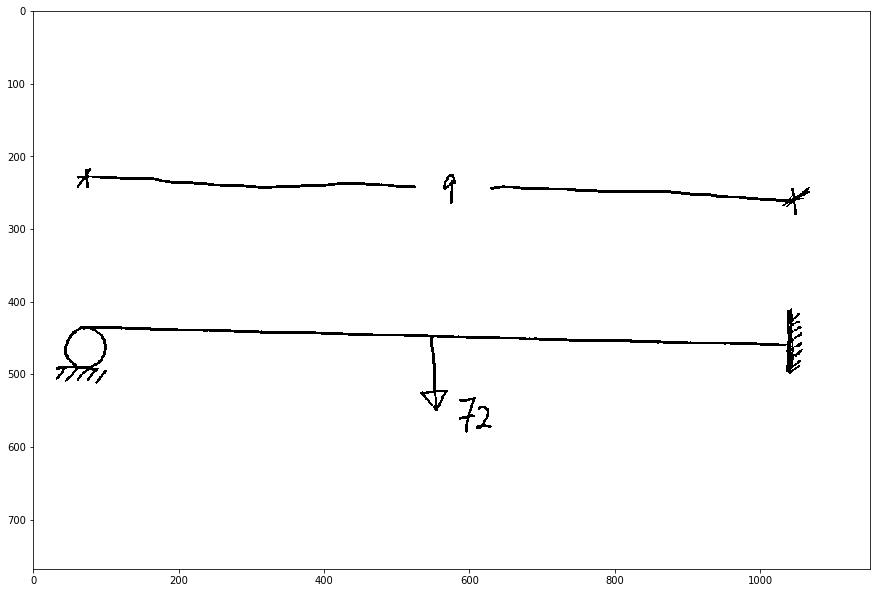

Loading image done... Time Elapsed : 0.6929619312286377 seconds...


In [3]:
start = time.time() # Begin time measurement

image_index = 50
image_set = np.load(PATH+'easy_training_images.npy')
image = np.copy(image_set[:,:,image_index])
image_set = None #clear image_set
gc.collect() #clear unreferenced data

l,w = 15,15 #dimension scales of print
print_image_bw(image,l,w)
      
end = time.time()#record time
time_cost_time_list = store_time(0,time_cost_time_list,end-start)
print_time_string(0,time_cost_string_list,time_cost_time_list)

# Component Segmentation
##### Using the ComponentSegmentation class:
    1. Selective Search is applied to the image (to generate bounding boxes)
    2. A merging algorithm is applied to the selective search bounding boxes (to merge highly overlapping bounding boxes)
##### The ComponentSegmentation uses the following data for initialization:
    - image: binary (grayscale) 2-D array for region proposal
    - name: for unique prints saving
    - min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio: for noise reduction
    - overlap_repeats, overlap_threshold: for merging algorithm
##### Then, the RoI proposal is done using the custom search method, which uses the selective search hyper-parameters:
    - scale_input
    - sigma_input
    - min_size_input
##### Then, the merging algorithm is applied within the search function, and a merged_set is retrieved.

Premerged Set


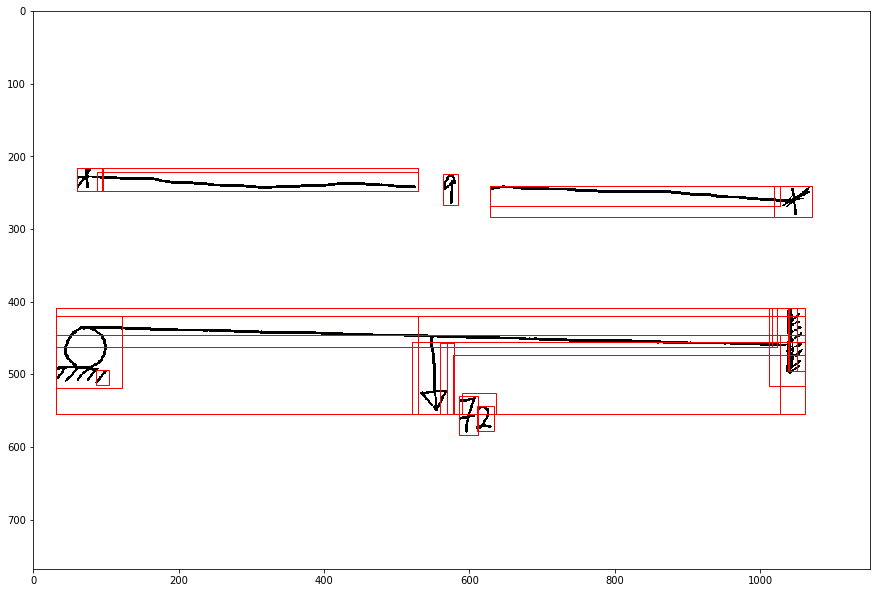

Merged Set


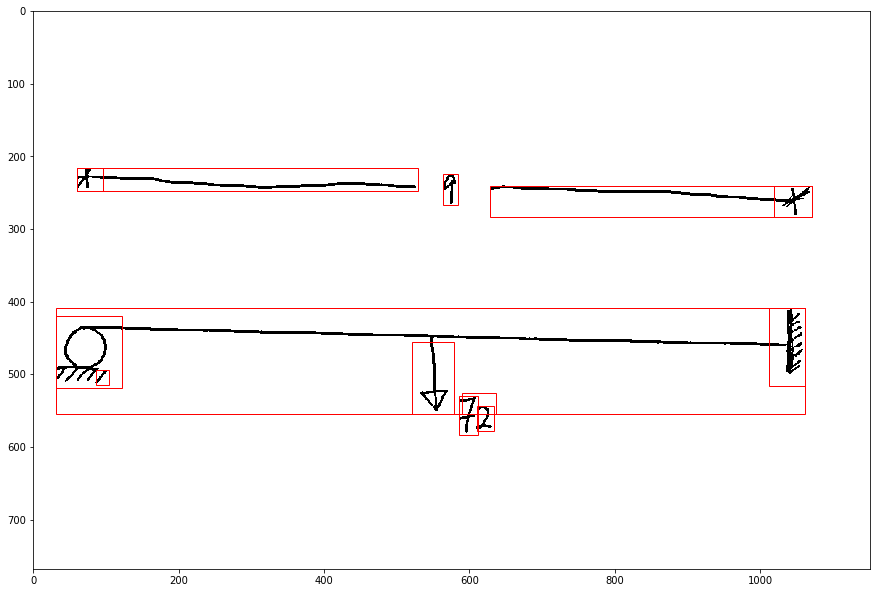

Component Segmentation done... Time Elapsed : 1.7518904209136963 seconds...


In [4]:
start = time.time() # Begin time measurement

#Create object ComponentSegmentation, which will use the search function to perform segmentation and merging.
segmentation_obj = ComponentSegmentation(image, name, min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio, overlap_repeats, overlap_threshold)
segmentation_obj.search(scale_input, sigma_input, min_size_input) # run search (segmentation code)
merged_set = segmentation_obj.merged_set

end = time.time()#record time
time_cost_time_list = store_time(1,time_cost_time_list,end-start)
print_time_string(1,time_cost_string_list,time_cost_time_list)

# ExtractionPreprocessing
#### Merged set from ComponentSegmentation is passed to ExtractionPreprocessing and the following is applied:
    1. Trim: extra space around the farthest black pixels are removed
    2. Remove Unconnected Parts: extra pixels (from other components) captured by the bounding box are removed
    3. Trim: trimming again as empty spaces may be released
    4. Resize: extraction is resized to the prescribed 100x100 dimension using max pooling for downsampling to preserve data
ext_images_list = extraction images: list of 100x100 binary (grayscale) 2-D arrays<br>
ext_data_list = extraction data: list of x, y, w, h data of extractions bounding boxes<br> 
where:<br>
    - x, y: top-left corner coordinates of bounding box
    - w, h: width and height of bounding box respectively
#### The preprocess_extractions function is called and the extraction images and extraction data are acquired.
#### The plot_bounding_boxes_with_names function is then used to display the bounding boxes on the original image.

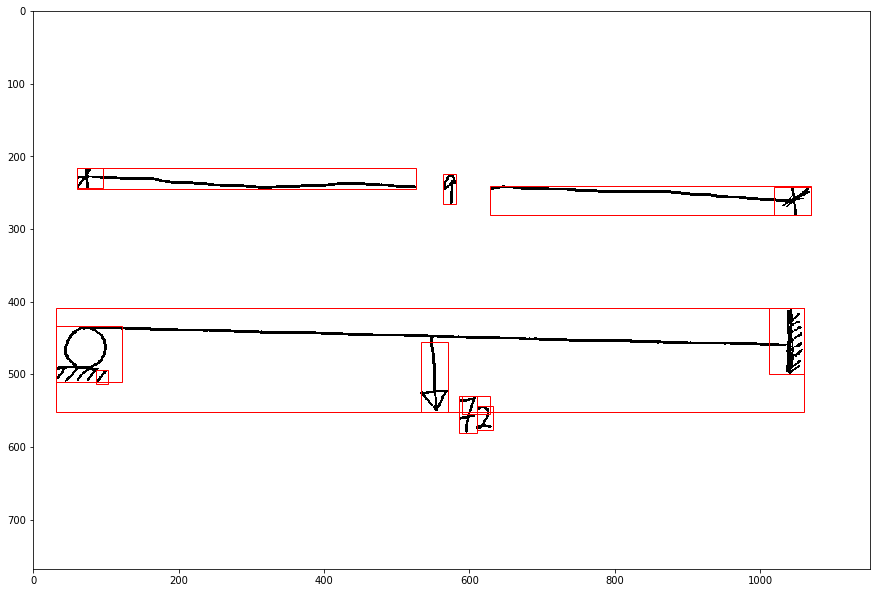

Extraction Preprocessing done... Time Elapsed : 2.2417259216308594 seconds...


In [5]:
start = time.time() # Begin time measurement

#Transport data into ExtractionPreprocessing class, which will trim, remove unconnected parts, then trim, and resize
extraction_obj = ExtractionPreprocessing(image, name, merged_set)

# Get 4 lists from preprocess_extractions function
ext_images_list, ext_data_list = extraction_obj.preprocess_extractions(wanted_w, wanted_h, export_w, export_h, max_piece_percent)
extraction_obj.plot_bounding_boxes_with_names()

end = time.time()#record time
time_cost_time_list = store_time(2,time_cost_time_list,end-start)
print_time_string(2,time_cost_string_list,time_cost_time_list)

# ComponentClassifierTraining (Not pre-trained)
### If model has been trained before:
### Then the train and save functions should be replaced with:
training_obj.model.load_weights(PATH+name+'.h5')
### Such that the below code is the following:
training_obj = ComponentClassifierTraining(PATH, data_set_name, num_classes, dropout, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)<br>
training_obj.shuffle_data(training_obj.load_data(PATH,data_set_name),1000)<br>
<br>
#Model is Sketch_a_net<br>
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])<br>
training_obj.model.load_weights(PATH+name+'.h5')<br>
##### The ComponentClassifierTraining object is first initialized with:
    - PATH: working directory
    - data_set_name: for loading training data set
    - num_classes, dropout: CNN model parameters
    - TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL: training parameters
##### The shuffle_data is then called to shuffle the training data using a seed<br>The Sketch_A_Net model is then loaded<br>Then the model is trained with 100 epochs<br>Then the model weights are saved<br>Finally the trained model is stored in trained_model to be passed onto a ComponentClassifierPredict object
#### If model weights have been trained before, the training and saving is not required, and the load_weights function has to be called instead.

In [6]:
start = time.time() # Begin time measurement

seed = 1000
i = 1234
training_obj = ComponentClassifierTraining(num_classes,TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.shuffle_data(training_obj.load_data(dataset_PATH,dataset_name),seed)

#Model is Sketch_a_net
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])

#training_obj.train(100,seed)
#training_obj.save(name+'_'+str(i))
training_obj.model.load_weights(dataset_PATH+name+'.h5')

trained_model = training_obj.model

end = time.time()#record time
time_cost_time_list = store_time(3,time_cost_time_list,end-start)
print_time_string(3,time_cost_string_list,time_cost_time_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 29, 64)        14464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 256)       295168    
__________

# ComponentClassifierPredict
### The ComponentClassifierPredict object is first initialized with the entropy-based hyperparameters:
    - min_percent_match
    - min_confidence
These parameters were explained in the Hyperparameters section above.
### The predict_classes function produces the following:
    - ext_class_index_list: ordered list of highest % match class predictions for each
The entropy-based modifications are applied to the above (such that if any of the two criteria are not satisfied, the prediction is classified as random)
    - ext_class_name_list: ordered list of corresponding names to ext_class_index_list
    - ext_match_first_max_percent_list: ordered list of corresponding first-highest match percentage
    - ext_match_second_max_percent_list: ordered list of corresponding second-highest match percentage

In [7]:
start = time.time() # Begin time measurement

prediction_obj = ComponentClassifierPredict(min_percent_match, min_confidence)

ext_class_index_list, ext_class_name_list, \
ext_match_first_max_percent_list, \
ext_match_second_max_percent_list = prediction_obj.predict_classes(ext_images_list,trained_model)

end = time.time()#record time
time_cost_time_list = store_time(4,time_cost_time_list,end-start)
print_time_string(4,time_cost_string_list,time_cost_time_list)

Component Classifier Predict done... Time Elapsed : 0.3371281623840332 seconds...


# Printing Results
#### Results are plotted on the original image using:
    - image: for background
    - name: for saving
    - ext_data_list: list of x, y, w, h coordinates for each bounding box
    - ext_class_index_list: list of predicted class indices
    - ext_class_name_list: list of corresponding class names per predicted index
    - ground_truth_index_list: list of ground truth class indices (currently set as the predicted classes.)*
##### Each bounding box is labelled with two items separated by a colon:
    - First: index of that object in the full list.
    - Second: predicted class name of that object.
##### If the predicted class matches with the ground truth class, <br> then the predicted label is coloured green, otherwise it is red. <br> * For this example, the ground truth labels were set as the predicted classes, so all labels are green.

C:\Users\JustinSanJuan\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:571: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\JustinSanJuan\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:574: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\JustinSanJuan\Desktop\Workspace\python\isa_python\adjustText.py:31: RuntimeWarning: invalid value encountered in greater
  y_in = np.logical_and(y>y1, y<y2)
C:\Users\JustinSanJuan\Desktop\Workspace\python\isa_python\adjustText.py:31: RuntimeWarning: invalid value encountered in less
  y_in = np.logical_and(y>y1, y<y2)


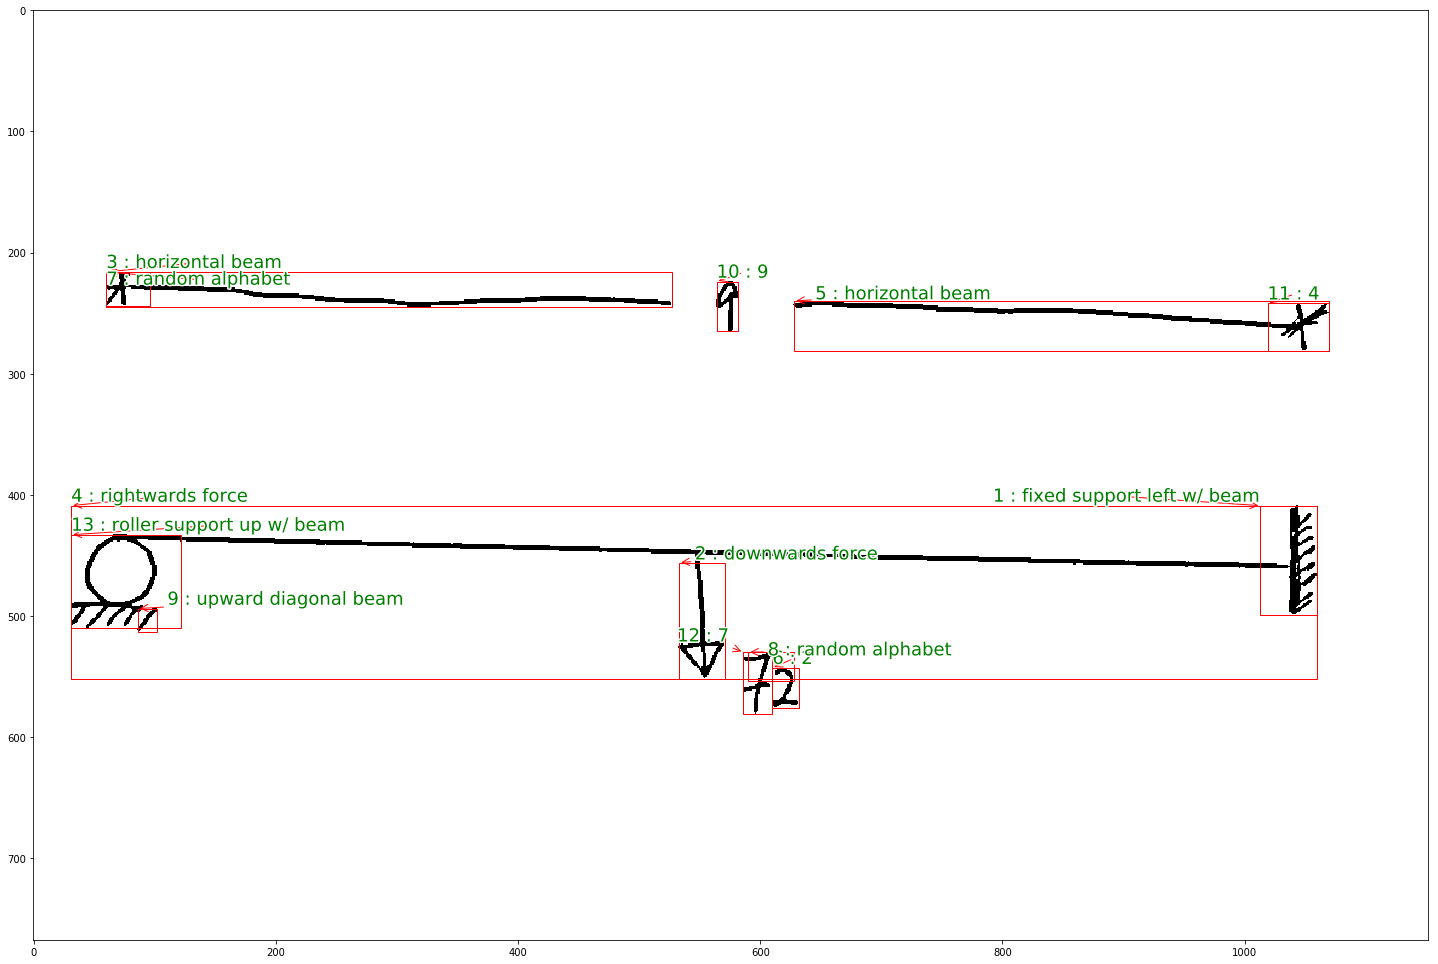

Printing Results done... Time Elapsed : 2.003979444503784 seconds...


In [8]:
start = time.time() # Begin time measurement

ground_truth_index_list = ext_class_index_list # set all answers as correct answers for now
plot_model_results_and_save(image,name, ext_data_list, ext_class_index_list, ext_class_name_list, ground_truth_index_list)

end = time.time()#record time
time_cost_time_list = store_time(5,time_cost_time_list,end-start)
print_time_string(5,time_cost_string_list,time_cost_time_list)

# ExtractionLabelling
#### The ExtractionLabelling class is used to label the problem image with ground truths in the form of x, y, w, h, c <br>where x, y, w, h are the coordinates of the bounding box, and c is the class of the object in the box.
#### The class is an interactive program where the user will be asked to verify the correctness <br> of the bounding box regions and classes predicted by the current best segmentation + classification algorithm.
##### The class is initialized using:
    - PATH: working directory
    - ext_images_list: list of extraction images
    - ext_data_list: list of extraction image coordinates (x, y, w, h)
    - ext_class_index_list: list of predicted class indices (c)
    - ext_class_name_list: list of predicted class names
    - num_classes, img_rows, img_cols: selected CNN model parameters
##### The define_model function is then called to load the model (from the trained_model variable). <br> Then the select_good_bounding_boxes function is called to allow the user to verify the bounding boxes and predicted classes. <br> Finally, after all the objects have been segmented and classified and saved in a text file, the data is plotted on the original image.
##### The process of the interactive program is described in the diagram below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/extraction-labelling-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

printing ground truths for review...


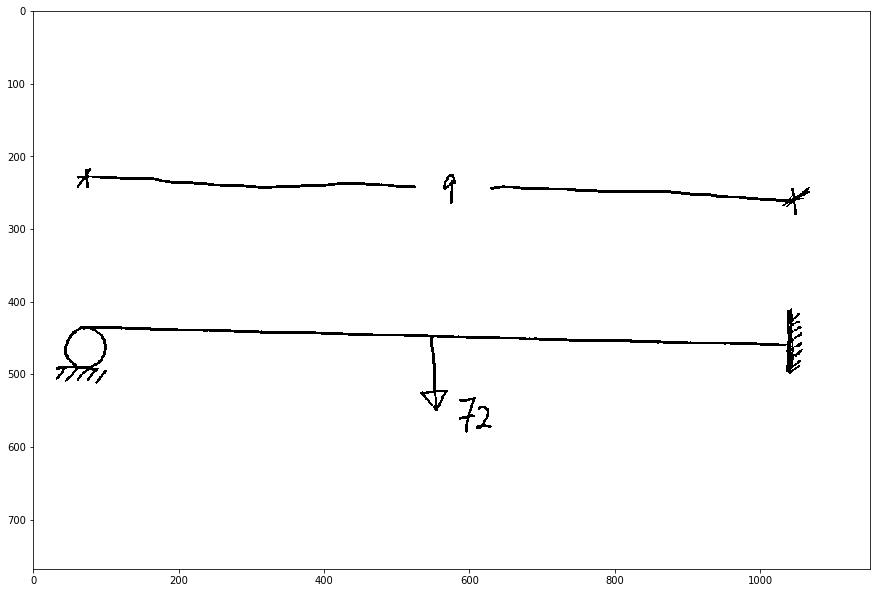

Acquiring and Printing Ground Truth Data done... Time Elapsed : 0.34856319427490234 seconds...


In [9]:
start = time.time() # Begin time measurement

labelling_obj = ExtractionLabelling(ext_images_list, ext_data_list,ext_class_index_list, ext_class_name_list, 
                          num_classes, img_rows, img_cols)

labelling_obj.define_model(trained_model)

### Long procedure
#labelling_obj.select_good_bounding_boxes(image, dataset_PATH,"easy_" + str(image_index))
labelling_obj.plot_ground_truths(image, dataset_PATH,"easy_" + str(image_index))

end = time.time()#record time
time_cost_time_list = store_time(6,time_cost_time_list,end-start)
print_time_string(6,time_cost_string_list,time_cost_time_list)

# Active Learning<br>Data Concatenation & Cleaning
#### A dataset by name is added into the training dataset for improvement in accuracy

In [11]:
start = time.time() # Begin time measurement

dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_29724" # base training images
dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_13291" # problem ground truth images
dataset_name_list = [dataset_name_1, dataset_name_2]

### Long procedure
cleaned_datasets_list = labelling_obj.clean_datasets(dataset_PATH,dataset_name_list)
final_dataset_name = labelling_obj.concatenate_datasets(dataset_PATH, cleaned_datasets_list, start, end) #**kwargs: suffix, exclude


end = time.time()#record time
time_cost_time_list = store_time(7,time_cost_time_list,end-start)
print_time_string(7,time_cost_string_list,time_cost_time_list)

saved as :C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/Training_Samples_64_classes_100x100_all_cleaned_29724
saved as :C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/Training_Samples_64_classes_100x100_all_cleaned_13291
Updating answers...
Adding 0 training samples to training set...
Inital length = 29724
0 / 29724 of data_all
1 / 29724 of data_all
2 / 29724 of data_all
3 / 29724 of data_all
4 / 29724 of data_all
5 / 29724 of data_all
6 / 29724 of data_all
7 / 29724 of data_all
8 / 29724 of data_all
9 / 29724 of data_all
10 / 29724 of data_all
11 / 29724 of data_all
12 / 29724 of data_all
13 / 29724 of data_all
14 / 29724 of data_all
15 / 29724 of data_all
16 / 29724 of data_all
17 / 29724 of data_all
18 / 29724 of data_all
19 / 29724 of data_all
20 / 29724 of data_all
21 / 29724 of data_all
22 / 29724 of data_all
23 / 29724 of data_all
24 / 29724 of

380 / 29724 of data_all
381 / 29724 of data_all
382 / 29724 of data_all
383 / 29724 of data_all
384 / 29724 of data_all
385 / 29724 of data_all
386 / 29724 of data_all
387 / 29724 of data_all
388 / 29724 of data_all
389 / 29724 of data_all
390 / 29724 of data_all
391 / 29724 of data_all
392 / 29724 of data_all
393 / 29724 of data_all
394 / 29724 of data_all
395 / 29724 of data_all
396 / 29724 of data_all
397 / 29724 of data_all
398 / 29724 of data_all
399 / 29724 of data_all
400 / 29724 of data_all
401 / 29724 of data_all
402 / 29724 of data_all
403 / 29724 of data_all
404 / 29724 of data_all
405 / 29724 of data_all
406 / 29724 of data_all
407 / 29724 of data_all
408 / 29724 of data_all
409 / 29724 of data_all
410 / 29724 of data_all
411 / 29724 of data_all
412 / 29724 of data_all
413 / 29724 of data_all
414 / 29724 of data_all
415 / 29724 of data_all
416 / 29724 of data_all
417 / 29724 of data_all
418 / 29724 of data_all
419 / 29724 of data_all
420 / 29724 of data_all
421 / 29724 of d

1588 / 29724 of data_all
1589 / 29724 of data_all
1590 / 29724 of data_all
1591 / 29724 of data_all
1592 / 29724 of data_all
1593 / 29724 of data_all
1594 / 29724 of data_all
1595 / 29724 of data_all
1596 / 29724 of data_all
1597 / 29724 of data_all
1598 / 29724 of data_all
1599 / 29724 of data_all
1600 / 29724 of data_all
1601 / 29724 of data_all
1602 / 29724 of data_all
1603 / 29724 of data_all
1604 / 29724 of data_all
1605 / 29724 of data_all
1606 / 29724 of data_all
1607 / 29724 of data_all
1608 / 29724 of data_all
1609 / 29724 of data_all
1610 / 29724 of data_all
1611 / 29724 of data_all
1612 / 29724 of data_all
1613 / 29724 of data_all
1614 / 29724 of data_all
1615 / 29724 of data_all
1616 / 29724 of data_all
1617 / 29724 of data_all
1618 / 29724 of data_all
1619 / 29724 of data_all
1620 / 29724 of data_all
1621 / 29724 of data_all
1622 / 29724 of data_all
1623 / 29724 of data_all
1624 / 29724 of data_all
1625 / 29724 of data_all
1626 / 29724 of data_all
1627 / 29724 of data_all


2132 / 29724 of data_all
2133 / 29724 of data_all
2134 / 29724 of data_all
2135 / 29724 of data_all
2136 / 29724 of data_all
2137 / 29724 of data_all
2138 / 29724 of data_all
2139 / 29724 of data_all
2140 / 29724 of data_all
2141 / 29724 of data_all
2142 / 29724 of data_all
2143 / 29724 of data_all
2144 / 29724 of data_all
2145 / 29724 of data_all
2146 / 29724 of data_all
2147 / 29724 of data_all
2148 / 29724 of data_all
2149 / 29724 of data_all
2150 / 29724 of data_all
2151 / 29724 of data_all
2152 / 29724 of data_all
2153 / 29724 of data_all
2154 / 29724 of data_all
2155 / 29724 of data_all
2156 / 29724 of data_all
2157 / 29724 of data_all
2158 / 29724 of data_all
2159 / 29724 of data_all
2160 / 29724 of data_all
2161 / 29724 of data_all
2162 / 29724 of data_all
2163 / 29724 of data_all
2164 / 29724 of data_all
2165 / 29724 of data_all
2166 / 29724 of data_all
2167 / 29724 of data_all
2168 / 29724 of data_all
2169 / 29724 of data_all
2170 / 29724 of data_all
2171 / 29724 of data_all


2623 / 29724 of data_all
2624 / 29724 of data_all
2625 / 29724 of data_all
2626 / 29724 of data_all
2627 / 29724 of data_all
2628 / 29724 of data_all
2629 / 29724 of data_all
2630 / 29724 of data_all
2631 / 29724 of data_all
2632 / 29724 of data_all
2633 / 29724 of data_all
2634 / 29724 of data_all
2635 / 29724 of data_all
2636 / 29724 of data_all
2637 / 29724 of data_all
2638 / 29724 of data_all
2639 / 29724 of data_all
2640 / 29724 of data_all
2641 / 29724 of data_all
2642 / 29724 of data_all
2643 / 29724 of data_all
2644 / 29724 of data_all
2645 / 29724 of data_all
2646 / 29724 of data_all
2647 / 29724 of data_all
2648 / 29724 of data_all
2649 / 29724 of data_all
2650 / 29724 of data_all
2651 / 29724 of data_all
2652 / 29724 of data_all
2653 / 29724 of data_all
2654 / 29724 of data_all
2655 / 29724 of data_all
2656 / 29724 of data_all
2657 / 29724 of data_all
2658 / 29724 of data_all
2659 / 29724 of data_all
2660 / 29724 of data_all
2661 / 29724 of data_all
2662 / 29724 of data_all


3182 / 29724 of data_all
3183 / 29724 of data_all
3184 / 29724 of data_all
3185 / 29724 of data_all
3186 / 29724 of data_all
3187 / 29724 of data_all
3188 / 29724 of data_all
3189 / 29724 of data_all
3190 / 29724 of data_all
3191 / 29724 of data_all
3192 / 29724 of data_all
3193 / 29724 of data_all
3194 / 29724 of data_all
3195 / 29724 of data_all
3196 / 29724 of data_all
3197 / 29724 of data_all
3198 / 29724 of data_all
3199 / 29724 of data_all
3200 / 29724 of data_all
3201 / 29724 of data_all
3202 / 29724 of data_all
3203 / 29724 of data_all
3204 / 29724 of data_all
3205 / 29724 of data_all
3206 / 29724 of data_all
3207 / 29724 of data_all
3208 / 29724 of data_all
3209 / 29724 of data_all
3210 / 29724 of data_all
3211 / 29724 of data_all
3212 / 29724 of data_all
3213 / 29724 of data_all
3214 / 29724 of data_all
3215 / 29724 of data_all
3216 / 29724 of data_all
3217 / 29724 of data_all
3218 / 29724 of data_all
3219 / 29724 of data_all
3220 / 29724 of data_all
3221 / 29724 of data_all


3845 / 29724 of data_all
3846 / 29724 of data_all
3847 / 29724 of data_all
3848 / 29724 of data_all
3849 / 29724 of data_all
3850 / 29724 of data_all
3851 / 29724 of data_all
3852 / 29724 of data_all
3853 / 29724 of data_all
3854 / 29724 of data_all
3855 / 29724 of data_all
3856 / 29724 of data_all
3857 / 29724 of data_all
3858 / 29724 of data_all
3859 / 29724 of data_all
3860 / 29724 of data_all
3861 / 29724 of data_all
3862 / 29724 of data_all
3863 / 29724 of data_all
3864 / 29724 of data_all
3865 / 29724 of data_all
3866 / 29724 of data_all
3867 / 29724 of data_all
3868 / 29724 of data_all
3869 / 29724 of data_all
3870 / 29724 of data_all
3871 / 29724 of data_all
3872 / 29724 of data_all
3873 / 29724 of data_all
3874 / 29724 of data_all
3875 / 29724 of data_all
3876 / 29724 of data_all
3877 / 29724 of data_all
3878 / 29724 of data_all
3879 / 29724 of data_all
3880 / 29724 of data_all
3881 / 29724 of data_all
3882 / 29724 of data_all
3883 / 29724 of data_all
3884 / 29724 of data_all


4565 / 29724 of data_all
4566 / 29724 of data_all
4567 / 29724 of data_all
4568 / 29724 of data_all
4569 / 29724 of data_all
4570 / 29724 of data_all
4571 / 29724 of data_all
4572 / 29724 of data_all
4573 / 29724 of data_all
4574 / 29724 of data_all
4575 / 29724 of data_all
4576 / 29724 of data_all
4577 / 29724 of data_all
4578 / 29724 of data_all
4579 / 29724 of data_all
4580 / 29724 of data_all
4581 / 29724 of data_all
4582 / 29724 of data_all
4583 / 29724 of data_all
4584 / 29724 of data_all
4585 / 29724 of data_all
4586 / 29724 of data_all
4587 / 29724 of data_all
4588 / 29724 of data_all
4589 / 29724 of data_all
4590 / 29724 of data_all
4591 / 29724 of data_all
4592 / 29724 of data_all
4593 / 29724 of data_all
4594 / 29724 of data_all
4595 / 29724 of data_all
4596 / 29724 of data_all
4597 / 29724 of data_all
4598 / 29724 of data_all
4599 / 29724 of data_all
4600 / 29724 of data_all
4601 / 29724 of data_all
4602 / 29724 of data_all
4603 / 29724 of data_all
4604 / 29724 of data_all


5083 / 29724 of data_all
5084 / 29724 of data_all
5085 / 29724 of data_all
5086 / 29724 of data_all
5087 / 29724 of data_all
5088 / 29724 of data_all
5089 / 29724 of data_all
5090 / 29724 of data_all
5091 / 29724 of data_all
5092 / 29724 of data_all
5093 / 29724 of data_all
5094 / 29724 of data_all
5095 / 29724 of data_all
5096 / 29724 of data_all
5097 / 29724 of data_all
5098 / 29724 of data_all
5099 / 29724 of data_all
5100 / 29724 of data_all
5101 / 29724 of data_all
5102 / 29724 of data_all
5103 / 29724 of data_all
5104 / 29724 of data_all
5105 / 29724 of data_all
5106 / 29724 of data_all
5107 / 29724 of data_all
5108 / 29724 of data_all
5109 / 29724 of data_all
5110 / 29724 of data_all
5111 / 29724 of data_all
5112 / 29724 of data_all
5113 / 29724 of data_all
5114 / 29724 of data_all
5115 / 29724 of data_all
5116 / 29724 of data_all
5117 / 29724 of data_all
5118 / 29724 of data_all
5119 / 29724 of data_all
5120 / 29724 of data_all
5121 / 29724 of data_all
5122 / 29724 of data_all


5617 / 29724 of data_all
5618 / 29724 of data_all
5619 / 29724 of data_all
5620 / 29724 of data_all
5621 / 29724 of data_all
5622 / 29724 of data_all
5623 / 29724 of data_all
5624 / 29724 of data_all
5625 / 29724 of data_all
5626 / 29724 of data_all
5627 / 29724 of data_all
5628 / 29724 of data_all
5629 / 29724 of data_all
5630 / 29724 of data_all
5631 / 29724 of data_all
5632 / 29724 of data_all
5633 / 29724 of data_all
5634 / 29724 of data_all
5635 / 29724 of data_all
5636 / 29724 of data_all
5637 / 29724 of data_all
5638 / 29724 of data_all
5639 / 29724 of data_all
5640 / 29724 of data_all
5641 / 29724 of data_all
5642 / 29724 of data_all
5643 / 29724 of data_all
5644 / 29724 of data_all
5645 / 29724 of data_all
5646 / 29724 of data_all
5647 / 29724 of data_all
5648 / 29724 of data_all
5649 / 29724 of data_all
5650 / 29724 of data_all
5651 / 29724 of data_all
5652 / 29724 of data_all
5653 / 29724 of data_all
5654 / 29724 of data_all
5655 / 29724 of data_all
5656 / 29724 of data_all


6184 / 29724 of data_all
6185 / 29724 of data_all
6186 / 29724 of data_all
6187 / 29724 of data_all
6188 / 29724 of data_all
6189 / 29724 of data_all
6190 / 29724 of data_all
6191 / 29724 of data_all
6192 / 29724 of data_all
6193 / 29724 of data_all
6194 / 29724 of data_all
6195 / 29724 of data_all
6196 / 29724 of data_all
6197 / 29724 of data_all
6198 / 29724 of data_all
6199 / 29724 of data_all
6200 / 29724 of data_all
6201 / 29724 of data_all
6202 / 29724 of data_all
6203 / 29724 of data_all
6204 / 29724 of data_all
6205 / 29724 of data_all
6206 / 29724 of data_all
6207 / 29724 of data_all
6208 / 29724 of data_all
6209 / 29724 of data_all
6210 / 29724 of data_all
6211 / 29724 of data_all
6212 / 29724 of data_all
6213 / 29724 of data_all
6214 / 29724 of data_all
6215 / 29724 of data_all
6216 / 29724 of data_all
6217 / 29724 of data_all
6218 / 29724 of data_all
6219 / 29724 of data_all
6220 / 29724 of data_all
6221 / 29724 of data_all
6222 / 29724 of data_all
6223 / 29724 of data_all


6779 / 29724 of data_all
6780 / 29724 of data_all
6781 / 29724 of data_all
6782 / 29724 of data_all
6783 / 29724 of data_all
6784 / 29724 of data_all
6785 / 29724 of data_all
6786 / 29724 of data_all
6787 / 29724 of data_all
6788 / 29724 of data_all
6789 / 29724 of data_all
6790 / 29724 of data_all
6791 / 29724 of data_all
6792 / 29724 of data_all
6793 / 29724 of data_all
6794 / 29724 of data_all
6795 / 29724 of data_all
6796 / 29724 of data_all
6797 / 29724 of data_all
6798 / 29724 of data_all
6799 / 29724 of data_all
6800 / 29724 of data_all
6801 / 29724 of data_all
6802 / 29724 of data_all
6803 / 29724 of data_all
6804 / 29724 of data_all
6805 / 29724 of data_all
6806 / 29724 of data_all
6807 / 29724 of data_all
6808 / 29724 of data_all
6809 / 29724 of data_all
6810 / 29724 of data_all
6811 / 29724 of data_all
6812 / 29724 of data_all
6813 / 29724 of data_all
6814 / 29724 of data_all
6815 / 29724 of data_all
6816 / 29724 of data_all
6817 / 29724 of data_all
6818 / 29724 of data_all


7366 / 29724 of data_all
7367 / 29724 of data_all
7368 / 29724 of data_all
7369 / 29724 of data_all
7370 / 29724 of data_all
7371 / 29724 of data_all
7372 / 29724 of data_all
7373 / 29724 of data_all
7374 / 29724 of data_all
7375 / 29724 of data_all
7376 / 29724 of data_all
7377 / 29724 of data_all
7378 / 29724 of data_all
7379 / 29724 of data_all
7380 / 29724 of data_all
7381 / 29724 of data_all
7382 / 29724 of data_all
7383 / 29724 of data_all
7384 / 29724 of data_all
7385 / 29724 of data_all
7386 / 29724 of data_all
7387 / 29724 of data_all
7388 / 29724 of data_all
7389 / 29724 of data_all
7390 / 29724 of data_all
7391 / 29724 of data_all
7392 / 29724 of data_all
7393 / 29724 of data_all
7394 / 29724 of data_all
7395 / 29724 of data_all
7396 / 29724 of data_all
7397 / 29724 of data_all
7398 / 29724 of data_all
7399 / 29724 of data_all
7400 / 29724 of data_all
7401 / 29724 of data_all
7402 / 29724 of data_all
7403 / 29724 of data_all
7404 / 29724 of data_all
7405 / 29724 of data_all


8054 / 29724 of data_all
8055 / 29724 of data_all
8056 / 29724 of data_all
8057 / 29724 of data_all
8058 / 29724 of data_all
8059 / 29724 of data_all
8060 / 29724 of data_all
8061 / 29724 of data_all
8062 / 29724 of data_all
8063 / 29724 of data_all
8064 / 29724 of data_all
8065 / 29724 of data_all
8066 / 29724 of data_all
8067 / 29724 of data_all
8068 / 29724 of data_all
8069 / 29724 of data_all
8070 / 29724 of data_all
8071 / 29724 of data_all
8072 / 29724 of data_all
8073 / 29724 of data_all
8074 / 29724 of data_all
8075 / 29724 of data_all
8076 / 29724 of data_all
8077 / 29724 of data_all
8078 / 29724 of data_all
8079 / 29724 of data_all
8080 / 29724 of data_all
8081 / 29724 of data_all
8082 / 29724 of data_all
8083 / 29724 of data_all
8084 / 29724 of data_all
8085 / 29724 of data_all
8086 / 29724 of data_all
8087 / 29724 of data_all
8088 / 29724 of data_all
8089 / 29724 of data_all
8090 / 29724 of data_all
8091 / 29724 of data_all
8092 / 29724 of data_all
8093 / 29724 of data_all


8572 / 29724 of data_all
8573 / 29724 of data_all
8574 / 29724 of data_all
8575 / 29724 of data_all
8576 / 29724 of data_all
8577 / 29724 of data_all
8578 / 29724 of data_all
8579 / 29724 of data_all
8580 / 29724 of data_all
8581 / 29724 of data_all
8582 / 29724 of data_all
8583 / 29724 of data_all
8584 / 29724 of data_all
8585 / 29724 of data_all
8586 / 29724 of data_all
8587 / 29724 of data_all
8588 / 29724 of data_all
8589 / 29724 of data_all
8590 / 29724 of data_all
8591 / 29724 of data_all
8592 / 29724 of data_all
8593 / 29724 of data_all
8594 / 29724 of data_all
8595 / 29724 of data_all
8596 / 29724 of data_all
8597 / 29724 of data_all
8598 / 29724 of data_all
8599 / 29724 of data_all
8600 / 29724 of data_all
8601 / 29724 of data_all
8602 / 29724 of data_all
8603 / 29724 of data_all
8604 / 29724 of data_all
8605 / 29724 of data_all
8606 / 29724 of data_all
8607 / 29724 of data_all
8608 / 29724 of data_all
8609 / 29724 of data_all
8610 / 29724 of data_all
8611 / 29724 of data_all


9076 / 29724 of data_all
9077 / 29724 of data_all
9078 / 29724 of data_all
9079 / 29724 of data_all
9080 / 29724 of data_all
9081 / 29724 of data_all
9082 / 29724 of data_all
9083 / 29724 of data_all
9084 / 29724 of data_all
9085 / 29724 of data_all
9086 / 29724 of data_all
9087 / 29724 of data_all
9088 / 29724 of data_all
9089 / 29724 of data_all
9090 / 29724 of data_all
9091 / 29724 of data_all
9092 / 29724 of data_all
9093 / 29724 of data_all
9094 / 29724 of data_all
9095 / 29724 of data_all
9096 / 29724 of data_all
9097 / 29724 of data_all
9098 / 29724 of data_all
9099 / 29724 of data_all
9100 / 29724 of data_all
9101 / 29724 of data_all
9102 / 29724 of data_all
9103 / 29724 of data_all
9104 / 29724 of data_all
9105 / 29724 of data_all
9106 / 29724 of data_all
9107 / 29724 of data_all
9108 / 29724 of data_all
9109 / 29724 of data_all
9110 / 29724 of data_all
9111 / 29724 of data_all
9112 / 29724 of data_all
9113 / 29724 of data_all
9114 / 29724 of data_all
9115 / 29724 of data_all


9586 / 29724 of data_all
9587 / 29724 of data_all
9588 / 29724 of data_all
9589 / 29724 of data_all
9590 / 29724 of data_all
9591 / 29724 of data_all
9592 / 29724 of data_all
9593 / 29724 of data_all
9594 / 29724 of data_all
9595 / 29724 of data_all
9596 / 29724 of data_all
9597 / 29724 of data_all
9598 / 29724 of data_all
9599 / 29724 of data_all
9600 / 29724 of data_all
9601 / 29724 of data_all
9602 / 29724 of data_all
9603 / 29724 of data_all
9604 / 29724 of data_all
9605 / 29724 of data_all
9606 / 29724 of data_all
9607 / 29724 of data_all
9608 / 29724 of data_all
9609 / 29724 of data_all
9610 / 29724 of data_all
9611 / 29724 of data_all
9612 / 29724 of data_all
9613 / 29724 of data_all
9614 / 29724 of data_all
9615 / 29724 of data_all
9616 / 29724 of data_all
9617 / 29724 of data_all
9618 / 29724 of data_all
9619 / 29724 of data_all
9620 / 29724 of data_all
9621 / 29724 of data_all
9622 / 29724 of data_all
9623 / 29724 of data_all
9624 / 29724 of data_all
9625 / 29724 of data_all


10101 / 29724 of data_all
10102 / 29724 of data_all
10103 / 29724 of data_all
10104 / 29724 of data_all
10105 / 29724 of data_all
10106 / 29724 of data_all
10107 / 29724 of data_all
10108 / 29724 of data_all
10109 / 29724 of data_all
10110 / 29724 of data_all
10111 / 29724 of data_all
10112 / 29724 of data_all
10113 / 29724 of data_all
10114 / 29724 of data_all
10115 / 29724 of data_all
10116 / 29724 of data_all
10117 / 29724 of data_all
10118 / 29724 of data_all
10119 / 29724 of data_all
10120 / 29724 of data_all
10121 / 29724 of data_all
10122 / 29724 of data_all
10123 / 29724 of data_all
10124 / 29724 of data_all
10125 / 29724 of data_all
10126 / 29724 of data_all
10127 / 29724 of data_all
10128 / 29724 of data_all
10129 / 29724 of data_all
10130 / 29724 of data_all
10131 / 29724 of data_all
10132 / 29724 of data_all
10133 / 29724 of data_all
10134 / 29724 of data_all
10135 / 29724 of data_all
10136 / 29724 of data_all
10137 / 29724 of data_all
10138 / 29724 of data_all
10139 / 2972

10612 / 29724 of data_all
10613 / 29724 of data_all
10614 / 29724 of data_all
10615 / 29724 of data_all
10616 / 29724 of data_all
10617 / 29724 of data_all
10618 / 29724 of data_all
10619 / 29724 of data_all
10620 / 29724 of data_all
10621 / 29724 of data_all
10622 / 29724 of data_all
10623 / 29724 of data_all
10624 / 29724 of data_all
10625 / 29724 of data_all
10626 / 29724 of data_all
10627 / 29724 of data_all
10628 / 29724 of data_all
10629 / 29724 of data_all
10630 / 29724 of data_all
10631 / 29724 of data_all
10632 / 29724 of data_all
10633 / 29724 of data_all
10634 / 29724 of data_all
10635 / 29724 of data_all
10636 / 29724 of data_all
10637 / 29724 of data_all
10638 / 29724 of data_all
10639 / 29724 of data_all
10640 / 29724 of data_all
10641 / 29724 of data_all
10642 / 29724 of data_all
10643 / 29724 of data_all
10644 / 29724 of data_all
10645 / 29724 of data_all
10646 / 29724 of data_all
10647 / 29724 of data_all
10648 / 29724 of data_all
10649 / 29724 of data_all
10650 / 2972

11127 / 29724 of data_all
11128 / 29724 of data_all
11129 / 29724 of data_all
11130 / 29724 of data_all
11131 / 29724 of data_all
11132 / 29724 of data_all
11133 / 29724 of data_all
11134 / 29724 of data_all
11135 / 29724 of data_all
11136 / 29724 of data_all
11137 / 29724 of data_all
11138 / 29724 of data_all
11139 / 29724 of data_all
11140 / 29724 of data_all
11141 / 29724 of data_all
11142 / 29724 of data_all
11143 / 29724 of data_all
11144 / 29724 of data_all
11145 / 29724 of data_all
11146 / 29724 of data_all
11147 / 29724 of data_all
11148 / 29724 of data_all
11149 / 29724 of data_all
11150 / 29724 of data_all
11151 / 29724 of data_all
11152 / 29724 of data_all
11153 / 29724 of data_all
11154 / 29724 of data_all
11155 / 29724 of data_all
11156 / 29724 of data_all
11157 / 29724 of data_all
11158 / 29724 of data_all
11159 / 29724 of data_all
11160 / 29724 of data_all
11161 / 29724 of data_all
11162 / 29724 of data_all
11163 / 29724 of data_all
11164 / 29724 of data_all
11165 / 2972

11645 / 29724 of data_all
11646 / 29724 of data_all
11647 / 29724 of data_all
11648 / 29724 of data_all
11649 / 29724 of data_all
11650 / 29724 of data_all
11651 / 29724 of data_all
11652 / 29724 of data_all
11653 / 29724 of data_all
11654 / 29724 of data_all
11655 / 29724 of data_all
11656 / 29724 of data_all
11657 / 29724 of data_all
11658 / 29724 of data_all
11659 / 29724 of data_all
11660 / 29724 of data_all
11661 / 29724 of data_all
11662 / 29724 of data_all
11663 / 29724 of data_all
11664 / 29724 of data_all
11665 / 29724 of data_all
11666 / 29724 of data_all
11667 / 29724 of data_all
11668 / 29724 of data_all
11669 / 29724 of data_all
11670 / 29724 of data_all
11671 / 29724 of data_all
11672 / 29724 of data_all
11673 / 29724 of data_all
11674 / 29724 of data_all
11675 / 29724 of data_all
11676 / 29724 of data_all
11677 / 29724 of data_all
11678 / 29724 of data_all
11679 / 29724 of data_all
11680 / 29724 of data_all
11681 / 29724 of data_all
11682 / 29724 of data_all
11683 / 2972

12153 / 29724 of data_all
12154 / 29724 of data_all
12155 / 29724 of data_all
12156 / 29724 of data_all
12157 / 29724 of data_all
12158 / 29724 of data_all
12159 / 29724 of data_all
12160 / 29724 of data_all
12161 / 29724 of data_all
12162 / 29724 of data_all
12163 / 29724 of data_all
12164 / 29724 of data_all
12165 / 29724 of data_all
12166 / 29724 of data_all
12167 / 29724 of data_all
12168 / 29724 of data_all
12169 / 29724 of data_all
12170 / 29724 of data_all
12171 / 29724 of data_all
12172 / 29724 of data_all
12173 / 29724 of data_all
12174 / 29724 of data_all
12175 / 29724 of data_all
12176 / 29724 of data_all
12177 / 29724 of data_all
12178 / 29724 of data_all
12179 / 29724 of data_all
12180 / 29724 of data_all
12181 / 29724 of data_all
12182 / 29724 of data_all
12183 / 29724 of data_all
12184 / 29724 of data_all
12185 / 29724 of data_all
12186 / 29724 of data_all
12187 / 29724 of data_all
12188 / 29724 of data_all
12189 / 29724 of data_all
12190 / 29724 of data_all
12191 / 2972

12689 / 29724 of data_all
12690 / 29724 of data_all
12691 / 29724 of data_all
12692 / 29724 of data_all
12693 / 29724 of data_all
12694 / 29724 of data_all
12695 / 29724 of data_all
12696 / 29724 of data_all
12697 / 29724 of data_all
12698 / 29724 of data_all
12699 / 29724 of data_all
12700 / 29724 of data_all
12701 / 29724 of data_all
12702 / 29724 of data_all
12703 / 29724 of data_all
12704 / 29724 of data_all
12705 / 29724 of data_all
12706 / 29724 of data_all
12707 / 29724 of data_all
12708 / 29724 of data_all
12709 / 29724 of data_all
12710 / 29724 of data_all
12711 / 29724 of data_all
12712 / 29724 of data_all
12713 / 29724 of data_all
12714 / 29724 of data_all
12715 / 29724 of data_all
12716 / 29724 of data_all
12717 / 29724 of data_all
12718 / 29724 of data_all
12719 / 29724 of data_all
12720 / 29724 of data_all
12721 / 29724 of data_all
12722 / 29724 of data_all
12723 / 29724 of data_all
12724 / 29724 of data_all
12725 / 29724 of data_all
12726 / 29724 of data_all
12727 / 2972

13245 / 29724 of data_all
13246 / 29724 of data_all
13247 / 29724 of data_all
13248 / 29724 of data_all
13249 / 29724 of data_all
13250 / 29724 of data_all
13251 / 29724 of data_all
13252 / 29724 of data_all
13253 / 29724 of data_all
13254 / 29724 of data_all
13255 / 29724 of data_all
13256 / 29724 of data_all
13257 / 29724 of data_all
13258 / 29724 of data_all
13259 / 29724 of data_all
13260 / 29724 of data_all
13261 / 29724 of data_all
13262 / 29724 of data_all
13263 / 29724 of data_all
13264 / 29724 of data_all
13265 / 29724 of data_all
13266 / 29724 of data_all
13267 / 29724 of data_all
13268 / 29724 of data_all
13269 / 29724 of data_all
13270 / 29724 of data_all
13271 / 29724 of data_all
13272 / 29724 of data_all
13273 / 29724 of data_all
13274 / 29724 of data_all
13275 / 29724 of data_all
13276 / 29724 of data_all
13277 / 29724 of data_all
13278 / 29724 of data_all
13279 / 29724 of data_all
13280 / 29724 of data_all
13281 / 29724 of data_all
13282 / 29724 of data_all
13283 / 2972

13794 / 29724 of data_all
13795 / 29724 of data_all
13796 / 29724 of data_all
13797 / 29724 of data_all
13798 / 29724 of data_all
13799 / 29724 of data_all
13800 / 29724 of data_all
13801 / 29724 of data_all
13802 / 29724 of data_all
13803 / 29724 of data_all
13804 / 29724 of data_all
13805 / 29724 of data_all
13806 / 29724 of data_all
13807 / 29724 of data_all
13808 / 29724 of data_all
13809 / 29724 of data_all
13810 / 29724 of data_all
13811 / 29724 of data_all
13812 / 29724 of data_all
13813 / 29724 of data_all
13814 / 29724 of data_all
13815 / 29724 of data_all
13816 / 29724 of data_all
13817 / 29724 of data_all
13818 / 29724 of data_all
13819 / 29724 of data_all
13820 / 29724 of data_all
13821 / 29724 of data_all
13822 / 29724 of data_all
13823 / 29724 of data_all
13824 / 29724 of data_all
13825 / 29724 of data_all
13826 / 29724 of data_all
13827 / 29724 of data_all
13828 / 29724 of data_all
13829 / 29724 of data_all
13830 / 29724 of data_all
13831 / 29724 of data_all
13832 / 2972

14319 / 29724 of data_all
14320 / 29724 of data_all
14321 / 29724 of data_all
14322 / 29724 of data_all
14323 / 29724 of data_all
14324 / 29724 of data_all
14325 / 29724 of data_all
14326 / 29724 of data_all
14327 / 29724 of data_all
14328 / 29724 of data_all
14329 / 29724 of data_all
14330 / 29724 of data_all
14331 / 29724 of data_all
14332 / 29724 of data_all
14333 / 29724 of data_all
14334 / 29724 of data_all
14335 / 29724 of data_all
14336 / 29724 of data_all
14337 / 29724 of data_all
14338 / 29724 of data_all
14339 / 29724 of data_all
14340 / 29724 of data_all
14341 / 29724 of data_all
14342 / 29724 of data_all
14343 / 29724 of data_all
14344 / 29724 of data_all
14345 / 29724 of data_all
14346 / 29724 of data_all
14347 / 29724 of data_all
14348 / 29724 of data_all
14349 / 29724 of data_all
14350 / 29724 of data_all
14351 / 29724 of data_all
14352 / 29724 of data_all
14353 / 29724 of data_all
14354 / 29724 of data_all
14355 / 29724 of data_all
14356 / 29724 of data_all
14357 / 2972

14857 / 29724 of data_all
14858 / 29724 of data_all
14859 / 29724 of data_all
14860 / 29724 of data_all
14861 / 29724 of data_all
14862 / 29724 of data_all
14863 / 29724 of data_all
14864 / 29724 of data_all
14865 / 29724 of data_all
14866 / 29724 of data_all
14867 / 29724 of data_all
14868 / 29724 of data_all
14869 / 29724 of data_all
14870 / 29724 of data_all
14871 / 29724 of data_all
14872 / 29724 of data_all
14873 / 29724 of data_all
14874 / 29724 of data_all
14875 / 29724 of data_all
14876 / 29724 of data_all
14877 / 29724 of data_all
14878 / 29724 of data_all
14879 / 29724 of data_all
14880 / 29724 of data_all
14881 / 29724 of data_all
14882 / 29724 of data_all
14883 / 29724 of data_all
14884 / 29724 of data_all
14885 / 29724 of data_all
14886 / 29724 of data_all
14887 / 29724 of data_all
14888 / 29724 of data_all
14889 / 29724 of data_all
14890 / 29724 of data_all
14891 / 29724 of data_all
14892 / 29724 of data_all
14893 / 29724 of data_all
14894 / 29724 of data_all
14895 / 2972

15432 / 29724 of data_all
15433 / 29724 of data_all
15434 / 29724 of data_all
15435 / 29724 of data_all
15436 / 29724 of data_all
15437 / 29724 of data_all
15438 / 29724 of data_all
15439 / 29724 of data_all
15440 / 29724 of data_all
15441 / 29724 of data_all
15442 / 29724 of data_all
15443 / 29724 of data_all
15444 / 29724 of data_all
15445 / 29724 of data_all
15446 / 29724 of data_all
15447 / 29724 of data_all
15448 / 29724 of data_all
15449 / 29724 of data_all
15450 / 29724 of data_all
15451 / 29724 of data_all
15452 / 29724 of data_all
15453 / 29724 of data_all
15454 / 29724 of data_all
15455 / 29724 of data_all
15456 / 29724 of data_all
15457 / 29724 of data_all
15458 / 29724 of data_all
15459 / 29724 of data_all
15460 / 29724 of data_all
15461 / 29724 of data_all
15462 / 29724 of data_all
15463 / 29724 of data_all
15464 / 29724 of data_all
15465 / 29724 of data_all
15466 / 29724 of data_all
15467 / 29724 of data_all
15468 / 29724 of data_all
15469 / 29724 of data_all
15470 / 2972

15925 / 29724 of data_all
15926 / 29724 of data_all
15927 / 29724 of data_all
15928 / 29724 of data_all
15929 / 29724 of data_all
15930 / 29724 of data_all
15931 / 29724 of data_all
15932 / 29724 of data_all
15933 / 29724 of data_all
15934 / 29724 of data_all
15935 / 29724 of data_all
15936 / 29724 of data_all
15937 / 29724 of data_all
15938 / 29724 of data_all
15939 / 29724 of data_all
15940 / 29724 of data_all
15941 / 29724 of data_all
15942 / 29724 of data_all
15943 / 29724 of data_all
15944 / 29724 of data_all
15945 / 29724 of data_all
15946 / 29724 of data_all
15947 / 29724 of data_all
15948 / 29724 of data_all
15949 / 29724 of data_all
15950 / 29724 of data_all
15951 / 29724 of data_all
15952 / 29724 of data_all
15953 / 29724 of data_all
15954 / 29724 of data_all
15955 / 29724 of data_all
15956 / 29724 of data_all
15957 / 29724 of data_all
15958 / 29724 of data_all
15959 / 29724 of data_all
15960 / 29724 of data_all
15961 / 29724 of data_all
15962 / 29724 of data_all
15963 / 2972

16485 / 29724 of data_all
16486 / 29724 of data_all
16487 / 29724 of data_all
16488 / 29724 of data_all
16489 / 29724 of data_all
16490 / 29724 of data_all
16491 / 29724 of data_all
16492 / 29724 of data_all
16493 / 29724 of data_all
16494 / 29724 of data_all
16495 / 29724 of data_all
16496 / 29724 of data_all
16497 / 29724 of data_all
16498 / 29724 of data_all
16499 / 29724 of data_all
16500 / 29724 of data_all
16501 / 29724 of data_all
16502 / 29724 of data_all
16503 / 29724 of data_all
16504 / 29724 of data_all
16505 / 29724 of data_all
16506 / 29724 of data_all
16507 / 29724 of data_all
16508 / 29724 of data_all
16509 / 29724 of data_all
16510 / 29724 of data_all
16511 / 29724 of data_all
16512 / 29724 of data_all
16513 / 29724 of data_all
16514 / 29724 of data_all
16515 / 29724 of data_all
16516 / 29724 of data_all
16517 / 29724 of data_all
16518 / 29724 of data_all
16519 / 29724 of data_all
16520 / 29724 of data_all
16521 / 29724 of data_all
16522 / 29724 of data_all
16523 / 2972

17048 / 29724 of data_all
17049 / 29724 of data_all
17050 / 29724 of data_all
17051 / 29724 of data_all
17052 / 29724 of data_all
17053 / 29724 of data_all
17054 / 29724 of data_all
17055 / 29724 of data_all
17056 / 29724 of data_all
17057 / 29724 of data_all
17058 / 29724 of data_all
17059 / 29724 of data_all
17060 / 29724 of data_all
17061 / 29724 of data_all
17062 / 29724 of data_all
17063 / 29724 of data_all
17064 / 29724 of data_all
17065 / 29724 of data_all
17066 / 29724 of data_all
17067 / 29724 of data_all
17068 / 29724 of data_all
17069 / 29724 of data_all
17070 / 29724 of data_all
17071 / 29724 of data_all
17072 / 29724 of data_all
17073 / 29724 of data_all
17074 / 29724 of data_all
17075 / 29724 of data_all
17076 / 29724 of data_all
17077 / 29724 of data_all
17078 / 29724 of data_all
17079 / 29724 of data_all
17080 / 29724 of data_all
17081 / 29724 of data_all
17082 / 29724 of data_all
17083 / 29724 of data_all
17084 / 29724 of data_all
17085 / 29724 of data_all
17086 / 2972

17556 / 29724 of data_all
17557 / 29724 of data_all
17558 / 29724 of data_all
17559 / 29724 of data_all
17560 / 29724 of data_all
17561 / 29724 of data_all
17562 / 29724 of data_all
17563 / 29724 of data_all
17564 / 29724 of data_all
17565 / 29724 of data_all
17566 / 29724 of data_all
17567 / 29724 of data_all
17568 / 29724 of data_all
17569 / 29724 of data_all
17570 / 29724 of data_all
17571 / 29724 of data_all
17572 / 29724 of data_all
17573 / 29724 of data_all
17574 / 29724 of data_all
17575 / 29724 of data_all
17576 / 29724 of data_all
17577 / 29724 of data_all
17578 / 29724 of data_all
17579 / 29724 of data_all
17580 / 29724 of data_all
17581 / 29724 of data_all
17582 / 29724 of data_all
17583 / 29724 of data_all
17584 / 29724 of data_all
17585 / 29724 of data_all
17586 / 29724 of data_all
17587 / 29724 of data_all
17588 / 29724 of data_all
17589 / 29724 of data_all
17590 / 29724 of data_all
17591 / 29724 of data_all
17592 / 29724 of data_all
17593 / 29724 of data_all
17594 / 2972

18010 / 29724 of data_all
18011 / 29724 of data_all
18012 / 29724 of data_all
18013 / 29724 of data_all
18014 / 29724 of data_all
18015 / 29724 of data_all
18016 / 29724 of data_all
18017 / 29724 of data_all
18018 / 29724 of data_all
18019 / 29724 of data_all
18020 / 29724 of data_all
18021 / 29724 of data_all
18022 / 29724 of data_all
18023 / 29724 of data_all
18024 / 29724 of data_all
18025 / 29724 of data_all
18026 / 29724 of data_all
18027 / 29724 of data_all
18028 / 29724 of data_all
18029 / 29724 of data_all
18030 / 29724 of data_all
18031 / 29724 of data_all
18032 / 29724 of data_all
18033 / 29724 of data_all
18034 / 29724 of data_all
18035 / 29724 of data_all
18036 / 29724 of data_all
18037 / 29724 of data_all
18038 / 29724 of data_all
18039 / 29724 of data_all
18040 / 29724 of data_all
18041 / 29724 of data_all
18042 / 29724 of data_all
18043 / 29724 of data_all
18044 / 29724 of data_all
18045 / 29724 of data_all
18046 / 29724 of data_all
18047 / 29724 of data_all
18048 / 2972

18450 / 29724 of data_all
18451 / 29724 of data_all
18452 / 29724 of data_all
18453 / 29724 of data_all
18454 / 29724 of data_all
18455 / 29724 of data_all
18456 / 29724 of data_all
18457 / 29724 of data_all
18458 / 29724 of data_all
18459 / 29724 of data_all
18460 / 29724 of data_all
18461 / 29724 of data_all
18462 / 29724 of data_all
18463 / 29724 of data_all
18464 / 29724 of data_all
18465 / 29724 of data_all
18466 / 29724 of data_all
18467 / 29724 of data_all
18468 / 29724 of data_all
18469 / 29724 of data_all
18470 / 29724 of data_all
18471 / 29724 of data_all
18472 / 29724 of data_all
18473 / 29724 of data_all
18474 / 29724 of data_all
18475 / 29724 of data_all
18476 / 29724 of data_all
18477 / 29724 of data_all
18478 / 29724 of data_all
18479 / 29724 of data_all
18480 / 29724 of data_all
18481 / 29724 of data_all
18482 / 29724 of data_all
18483 / 29724 of data_all
18484 / 29724 of data_all
18485 / 29724 of data_all
18486 / 29724 of data_all
18487 / 29724 of data_all
18488 / 2972

18920 / 29724 of data_all
18921 / 29724 of data_all
18922 / 29724 of data_all
18923 / 29724 of data_all
18924 / 29724 of data_all
18925 / 29724 of data_all
18926 / 29724 of data_all
18927 / 29724 of data_all
18928 / 29724 of data_all
18929 / 29724 of data_all
18930 / 29724 of data_all
18931 / 29724 of data_all
18932 / 29724 of data_all
18933 / 29724 of data_all
18934 / 29724 of data_all
18935 / 29724 of data_all
18936 / 29724 of data_all
18937 / 29724 of data_all
18938 / 29724 of data_all
18939 / 29724 of data_all
18940 / 29724 of data_all
18941 / 29724 of data_all
18942 / 29724 of data_all
18943 / 29724 of data_all
18944 / 29724 of data_all
18945 / 29724 of data_all
18946 / 29724 of data_all
18947 / 29724 of data_all
18948 / 29724 of data_all
18949 / 29724 of data_all
18950 / 29724 of data_all
18951 / 29724 of data_all
18952 / 29724 of data_all
18953 / 29724 of data_all
18954 / 29724 of data_all
18955 / 29724 of data_all
18956 / 29724 of data_all
18957 / 29724 of data_all
18958 / 2972

19309 / 29724 of data_all
19310 / 29724 of data_all
19311 / 29724 of data_all
19312 / 29724 of data_all
19313 / 29724 of data_all
19314 / 29724 of data_all
19315 / 29724 of data_all
19316 / 29724 of data_all
19317 / 29724 of data_all
19318 / 29724 of data_all
19319 / 29724 of data_all
19320 / 29724 of data_all
19321 / 29724 of data_all
19322 / 29724 of data_all
19323 / 29724 of data_all
19324 / 29724 of data_all
19325 / 29724 of data_all
19326 / 29724 of data_all
19327 / 29724 of data_all
19328 / 29724 of data_all
19329 / 29724 of data_all
19330 / 29724 of data_all
19331 / 29724 of data_all
19332 / 29724 of data_all
19333 / 29724 of data_all
19334 / 29724 of data_all
19335 / 29724 of data_all
19336 / 29724 of data_all
19337 / 29724 of data_all
19338 / 29724 of data_all
19339 / 29724 of data_all
19340 / 29724 of data_all
19341 / 29724 of data_all
19342 / 29724 of data_all
19343 / 29724 of data_all
19344 / 29724 of data_all
19345 / 29724 of data_all
19346 / 29724 of data_all
19347 / 2972

19750 / 29724 of data_all
19751 / 29724 of data_all
19752 / 29724 of data_all
19753 / 29724 of data_all
19754 / 29724 of data_all
19755 / 29724 of data_all
19756 / 29724 of data_all
19757 / 29724 of data_all
19758 / 29724 of data_all
19759 / 29724 of data_all
19760 / 29724 of data_all
19761 / 29724 of data_all
19762 / 29724 of data_all
19763 / 29724 of data_all
19764 / 29724 of data_all
19765 / 29724 of data_all
19766 / 29724 of data_all
19767 / 29724 of data_all
19768 / 29724 of data_all
19769 / 29724 of data_all
19770 / 29724 of data_all
19771 / 29724 of data_all
19772 / 29724 of data_all
19773 / 29724 of data_all
19774 / 29724 of data_all
19775 / 29724 of data_all
19776 / 29724 of data_all
19777 / 29724 of data_all
19778 / 29724 of data_all
19779 / 29724 of data_all
19780 / 29724 of data_all
19781 / 29724 of data_all
19782 / 29724 of data_all
19783 / 29724 of data_all
19784 / 29724 of data_all
19785 / 29724 of data_all
19786 / 29724 of data_all
19787 / 29724 of data_all
19788 / 2972

20263 / 29724 of data_all
20264 / 29724 of data_all
20265 / 29724 of data_all
20266 / 29724 of data_all
20267 / 29724 of data_all
20268 / 29724 of data_all
20269 / 29724 of data_all
20270 / 29724 of data_all
20271 / 29724 of data_all
20272 / 29724 of data_all
20273 / 29724 of data_all
20274 / 29724 of data_all
20275 / 29724 of data_all
20276 / 29724 of data_all
20277 / 29724 of data_all
20278 / 29724 of data_all
20279 / 29724 of data_all
20280 / 29724 of data_all
20281 / 29724 of data_all
20282 / 29724 of data_all
20283 / 29724 of data_all
20284 / 29724 of data_all
20285 / 29724 of data_all
20286 / 29724 of data_all
20287 / 29724 of data_all
20288 / 29724 of data_all
20289 / 29724 of data_all
20290 / 29724 of data_all
20291 / 29724 of data_all
20292 / 29724 of data_all
20293 / 29724 of data_all
20294 / 29724 of data_all
20295 / 29724 of data_all
20296 / 29724 of data_all
20297 / 29724 of data_all
20298 / 29724 of data_all
20299 / 29724 of data_all
20300 / 29724 of data_all
20301 / 2972

20807 / 29724 of data_all
20808 / 29724 of data_all
20809 / 29724 of data_all
20810 / 29724 of data_all
20811 / 29724 of data_all
20812 / 29724 of data_all
20813 / 29724 of data_all
20814 / 29724 of data_all
20815 / 29724 of data_all
20816 / 29724 of data_all
20817 / 29724 of data_all
20818 / 29724 of data_all
20819 / 29724 of data_all
20820 / 29724 of data_all
20821 / 29724 of data_all
20822 / 29724 of data_all
20823 / 29724 of data_all
20824 / 29724 of data_all
20825 / 29724 of data_all
20826 / 29724 of data_all
20827 / 29724 of data_all
20828 / 29724 of data_all
20829 / 29724 of data_all
20830 / 29724 of data_all
20831 / 29724 of data_all
20832 / 29724 of data_all
20833 / 29724 of data_all
20834 / 29724 of data_all
20835 / 29724 of data_all
20836 / 29724 of data_all
20837 / 29724 of data_all
20838 / 29724 of data_all
20839 / 29724 of data_all
20840 / 29724 of data_all
20841 / 29724 of data_all
20842 / 29724 of data_all
20843 / 29724 of data_all
20844 / 29724 of data_all
20845 / 2972

21260 / 29724 of data_all
21261 / 29724 of data_all
21262 / 29724 of data_all
21263 / 29724 of data_all
21264 / 29724 of data_all
21265 / 29724 of data_all
21266 / 29724 of data_all
21267 / 29724 of data_all
21268 / 29724 of data_all
21269 / 29724 of data_all
21270 / 29724 of data_all
21271 / 29724 of data_all
21272 / 29724 of data_all
21273 / 29724 of data_all
21274 / 29724 of data_all
21275 / 29724 of data_all
21276 / 29724 of data_all
21277 / 29724 of data_all
21278 / 29724 of data_all
21279 / 29724 of data_all
21280 / 29724 of data_all
21281 / 29724 of data_all
21282 / 29724 of data_all
21283 / 29724 of data_all
21284 / 29724 of data_all
21285 / 29724 of data_all
21286 / 29724 of data_all
21287 / 29724 of data_all
21288 / 29724 of data_all
21289 / 29724 of data_all
21290 / 29724 of data_all
21291 / 29724 of data_all
21292 / 29724 of data_all
21293 / 29724 of data_all
21294 / 29724 of data_all
21295 / 29724 of data_all
21296 / 29724 of data_all
21297 / 29724 of data_all
21298 / 2972

21639 / 29724 of data_all
21640 / 29724 of data_all
21641 / 29724 of data_all
21642 / 29724 of data_all
21643 / 29724 of data_all
21644 / 29724 of data_all
21645 / 29724 of data_all
21646 / 29724 of data_all
21647 / 29724 of data_all
21648 / 29724 of data_all
21649 / 29724 of data_all
21650 / 29724 of data_all
21651 / 29724 of data_all
21652 / 29724 of data_all
21653 / 29724 of data_all
21654 / 29724 of data_all
21655 / 29724 of data_all
21656 / 29724 of data_all
21657 / 29724 of data_all
21658 / 29724 of data_all
21659 / 29724 of data_all
21660 / 29724 of data_all
21661 / 29724 of data_all
21662 / 29724 of data_all
21663 / 29724 of data_all
21664 / 29724 of data_all
21665 / 29724 of data_all
21666 / 29724 of data_all
21667 / 29724 of data_all
21668 / 29724 of data_all
21669 / 29724 of data_all
21670 / 29724 of data_all
21671 / 29724 of data_all
21672 / 29724 of data_all
21673 / 29724 of data_all
21674 / 29724 of data_all
21675 / 29724 of data_all
21676 / 29724 of data_all
21677 / 2972

22047 / 29724 of data_all
22048 / 29724 of data_all
22049 / 29724 of data_all
22050 / 29724 of data_all
22051 / 29724 of data_all
22052 / 29724 of data_all
22053 / 29724 of data_all
22054 / 29724 of data_all
22055 / 29724 of data_all
22056 / 29724 of data_all
22057 / 29724 of data_all
22058 / 29724 of data_all
22059 / 29724 of data_all
22060 / 29724 of data_all
22061 / 29724 of data_all
22062 / 29724 of data_all
22063 / 29724 of data_all
22064 / 29724 of data_all
22065 / 29724 of data_all
22066 / 29724 of data_all
22067 / 29724 of data_all
22068 / 29724 of data_all
22069 / 29724 of data_all
22070 / 29724 of data_all
22071 / 29724 of data_all
22072 / 29724 of data_all
22073 / 29724 of data_all
22074 / 29724 of data_all
22075 / 29724 of data_all
22076 / 29724 of data_all
22077 / 29724 of data_all
22078 / 29724 of data_all
22079 / 29724 of data_all
22080 / 29724 of data_all
22081 / 29724 of data_all
22082 / 29724 of data_all
22083 / 29724 of data_all
22084 / 29724 of data_all
22085 / 2972

22398 / 29724 of data_all
22399 / 29724 of data_all
22400 / 29724 of data_all
22401 / 29724 of data_all
22402 / 29724 of data_all
22403 / 29724 of data_all
22404 / 29724 of data_all
22405 / 29724 of data_all
22406 / 29724 of data_all
22407 / 29724 of data_all
22408 / 29724 of data_all
22409 / 29724 of data_all
22410 / 29724 of data_all
22411 / 29724 of data_all
22412 / 29724 of data_all
22413 / 29724 of data_all
22414 / 29724 of data_all
22415 / 29724 of data_all
22416 / 29724 of data_all
22417 / 29724 of data_all
22418 / 29724 of data_all
22419 / 29724 of data_all
22420 / 29724 of data_all
22421 / 29724 of data_all
22422 / 29724 of data_all
22423 / 29724 of data_all
22424 / 29724 of data_all
22425 / 29724 of data_all
22426 / 29724 of data_all
22427 / 29724 of data_all
22428 / 29724 of data_all
22429 / 29724 of data_all
22430 / 29724 of data_all
22431 / 29724 of data_all
22432 / 29724 of data_all
22433 / 29724 of data_all
22434 / 29724 of data_all
22435 / 29724 of data_all
22436 / 2972

22941 / 29724 of data_all
22942 / 29724 of data_all
22943 / 29724 of data_all
22944 / 29724 of data_all
22945 / 29724 of data_all
22946 / 29724 of data_all
22947 / 29724 of data_all
22948 / 29724 of data_all
22949 / 29724 of data_all
22950 / 29724 of data_all
22951 / 29724 of data_all
22952 / 29724 of data_all
22953 / 29724 of data_all
22954 / 29724 of data_all
22955 / 29724 of data_all
22956 / 29724 of data_all
22957 / 29724 of data_all
22958 / 29724 of data_all
22959 / 29724 of data_all
22960 / 29724 of data_all
22961 / 29724 of data_all
22962 / 29724 of data_all
22963 / 29724 of data_all
22964 / 29724 of data_all
22965 / 29724 of data_all
22966 / 29724 of data_all
22967 / 29724 of data_all
22968 / 29724 of data_all
22969 / 29724 of data_all
22970 / 29724 of data_all
22971 / 29724 of data_all
22972 / 29724 of data_all
22973 / 29724 of data_all
22974 / 29724 of data_all
22975 / 29724 of data_all
22976 / 29724 of data_all
22977 / 29724 of data_all
22978 / 29724 of data_all
22979 / 2972

23378 / 29724 of data_all
23379 / 29724 of data_all
23380 / 29724 of data_all
23381 / 29724 of data_all
23382 / 29724 of data_all
23383 / 29724 of data_all
23384 / 29724 of data_all
23385 / 29724 of data_all
23386 / 29724 of data_all
23387 / 29724 of data_all
23388 / 29724 of data_all
23389 / 29724 of data_all
23390 / 29724 of data_all
23391 / 29724 of data_all
23392 / 29724 of data_all
23393 / 29724 of data_all
23394 / 29724 of data_all
23395 / 29724 of data_all
23396 / 29724 of data_all
23397 / 29724 of data_all
23398 / 29724 of data_all
23399 / 29724 of data_all
23400 / 29724 of data_all
23401 / 29724 of data_all
23402 / 29724 of data_all
23403 / 29724 of data_all
23404 / 29724 of data_all
23405 / 29724 of data_all
23406 / 29724 of data_all
23407 / 29724 of data_all
23408 / 29724 of data_all
23409 / 29724 of data_all
23410 / 29724 of data_all
23411 / 29724 of data_all
23412 / 29724 of data_all
23413 / 29724 of data_all
23414 / 29724 of data_all
23415 / 29724 of data_all
23416 / 2972

23867 / 29724 of data_all
23868 / 29724 of data_all
23869 / 29724 of data_all
23870 / 29724 of data_all
23871 / 29724 of data_all
23872 / 29724 of data_all
23873 / 29724 of data_all
23874 / 29724 of data_all
23875 / 29724 of data_all
23876 / 29724 of data_all
23877 / 29724 of data_all
23878 / 29724 of data_all
23879 / 29724 of data_all
23880 / 29724 of data_all
23881 / 29724 of data_all
23882 / 29724 of data_all
23883 / 29724 of data_all
23884 / 29724 of data_all
23885 / 29724 of data_all
23886 / 29724 of data_all
23887 / 29724 of data_all
23888 / 29724 of data_all
23889 / 29724 of data_all
23890 / 29724 of data_all
23891 / 29724 of data_all
23892 / 29724 of data_all
23893 / 29724 of data_all
23894 / 29724 of data_all
23895 / 29724 of data_all
23896 / 29724 of data_all
23897 / 29724 of data_all
23898 / 29724 of data_all
23899 / 29724 of data_all
23900 / 29724 of data_all
23901 / 29724 of data_all
23902 / 29724 of data_all
23903 / 29724 of data_all
23904 / 29724 of data_all
23905 / 2972

24377 / 29724 of data_all
24378 / 29724 of data_all
24379 / 29724 of data_all
24380 / 29724 of data_all
24381 / 29724 of data_all
24382 / 29724 of data_all
24383 / 29724 of data_all
24384 / 29724 of data_all
24385 / 29724 of data_all
24386 / 29724 of data_all
24387 / 29724 of data_all
24388 / 29724 of data_all
24389 / 29724 of data_all
24390 / 29724 of data_all
24391 / 29724 of data_all
24392 / 29724 of data_all
24393 / 29724 of data_all
24394 / 29724 of data_all
24395 / 29724 of data_all
24396 / 29724 of data_all
24397 / 29724 of data_all
24398 / 29724 of data_all
24399 / 29724 of data_all
24400 / 29724 of data_all
24401 / 29724 of data_all
24402 / 29724 of data_all
24403 / 29724 of data_all
24404 / 29724 of data_all
24405 / 29724 of data_all
24406 / 29724 of data_all
24407 / 29724 of data_all
24408 / 29724 of data_all
24409 / 29724 of data_all
24410 / 29724 of data_all
24411 / 29724 of data_all
24412 / 29724 of data_all
24413 / 29724 of data_all
24414 / 29724 of data_all
24415 / 2972

24796 / 29724 of data_all
24797 / 29724 of data_all
24798 / 29724 of data_all
24799 / 29724 of data_all
24800 / 29724 of data_all
24801 / 29724 of data_all
24802 / 29724 of data_all
24803 / 29724 of data_all
24804 / 29724 of data_all
24805 / 29724 of data_all
24806 / 29724 of data_all
24807 / 29724 of data_all
24808 / 29724 of data_all
24809 / 29724 of data_all
24810 / 29724 of data_all
24811 / 29724 of data_all
24812 / 29724 of data_all
24813 / 29724 of data_all
24814 / 29724 of data_all
24815 / 29724 of data_all
24816 / 29724 of data_all
24817 / 29724 of data_all
24818 / 29724 of data_all
24819 / 29724 of data_all
24820 / 29724 of data_all
24821 / 29724 of data_all
24822 / 29724 of data_all
24823 / 29724 of data_all
24824 / 29724 of data_all
24825 / 29724 of data_all
24826 / 29724 of data_all
24827 / 29724 of data_all
24828 / 29724 of data_all
24829 / 29724 of data_all
24830 / 29724 of data_all
24831 / 29724 of data_all
24832 / 29724 of data_all
24833 / 29724 of data_all
24834 / 2972

25201 / 29724 of data_all
25202 / 29724 of data_all
25203 / 29724 of data_all
25204 / 29724 of data_all
25205 / 29724 of data_all
25206 / 29724 of data_all
25207 / 29724 of data_all
25208 / 29724 of data_all
25209 / 29724 of data_all
25210 / 29724 of data_all
25211 / 29724 of data_all
25212 / 29724 of data_all
25213 / 29724 of data_all
25214 / 29724 of data_all
25215 / 29724 of data_all
25216 / 29724 of data_all
25217 / 29724 of data_all
25218 / 29724 of data_all
25219 / 29724 of data_all
25220 / 29724 of data_all
25221 / 29724 of data_all
25222 / 29724 of data_all
25223 / 29724 of data_all
25224 / 29724 of data_all
25225 / 29724 of data_all
25226 / 29724 of data_all
25227 / 29724 of data_all
25228 / 29724 of data_all
25229 / 29724 of data_all
25230 / 29724 of data_all
25231 / 29724 of data_all
25232 / 29724 of data_all
25233 / 29724 of data_all
25234 / 29724 of data_all
25235 / 29724 of data_all
25236 / 29724 of data_all
25237 / 29724 of data_all
25238 / 29724 of data_all
25239 / 2972

25551 / 29724 of data_all
25552 / 29724 of data_all
25553 / 29724 of data_all
25554 / 29724 of data_all
25555 / 29724 of data_all
25556 / 29724 of data_all
25557 / 29724 of data_all
25558 / 29724 of data_all
25559 / 29724 of data_all
25560 / 29724 of data_all
25561 / 29724 of data_all
25562 / 29724 of data_all
25563 / 29724 of data_all
25564 / 29724 of data_all
25565 / 29724 of data_all
25566 / 29724 of data_all
25567 / 29724 of data_all
25568 / 29724 of data_all
25569 / 29724 of data_all
25570 / 29724 of data_all
25571 / 29724 of data_all
25572 / 29724 of data_all
25573 / 29724 of data_all
25574 / 29724 of data_all
25575 / 29724 of data_all
25576 / 29724 of data_all
25577 / 29724 of data_all
25578 / 29724 of data_all
25579 / 29724 of data_all
25580 / 29724 of data_all
25581 / 29724 of data_all
25582 / 29724 of data_all
25583 / 29724 of data_all
25584 / 29724 of data_all
25585 / 29724 of data_all
25586 / 29724 of data_all
25587 / 29724 of data_all
25588 / 29724 of data_all
25589 / 2972

25981 / 29724 of data_all
25982 / 29724 of data_all
25983 / 29724 of data_all
25984 / 29724 of data_all
25985 / 29724 of data_all
25986 / 29724 of data_all
25987 / 29724 of data_all
25988 / 29724 of data_all
25989 / 29724 of data_all
25990 / 29724 of data_all
25991 / 29724 of data_all
25992 / 29724 of data_all
25993 / 29724 of data_all
25994 / 29724 of data_all
25995 / 29724 of data_all
25996 / 29724 of data_all
25997 / 29724 of data_all
25998 / 29724 of data_all
25999 / 29724 of data_all
26000 / 29724 of data_all
26001 / 29724 of data_all
26002 / 29724 of data_all
26003 / 29724 of data_all
26004 / 29724 of data_all
26005 / 29724 of data_all
26006 / 29724 of data_all
26007 / 29724 of data_all
26008 / 29724 of data_all
26009 / 29724 of data_all
26010 / 29724 of data_all
26011 / 29724 of data_all
26012 / 29724 of data_all
26013 / 29724 of data_all
26014 / 29724 of data_all
26015 / 29724 of data_all
26016 / 29724 of data_all
26017 / 29724 of data_all
26018 / 29724 of data_all
26019 / 2972

26398 / 29724 of data_all
26399 / 29724 of data_all
26400 / 29724 of data_all
26401 / 29724 of data_all
26402 / 29724 of data_all
26403 / 29724 of data_all
26404 / 29724 of data_all
26405 / 29724 of data_all
26406 / 29724 of data_all
26407 / 29724 of data_all
26408 / 29724 of data_all
26409 / 29724 of data_all
26410 / 29724 of data_all
26411 / 29724 of data_all
26412 / 29724 of data_all
26413 / 29724 of data_all
26414 / 29724 of data_all
26415 / 29724 of data_all
26416 / 29724 of data_all
26417 / 29724 of data_all
26418 / 29724 of data_all
26419 / 29724 of data_all
26420 / 29724 of data_all
26421 / 29724 of data_all
26422 / 29724 of data_all
26423 / 29724 of data_all
26424 / 29724 of data_all
26425 / 29724 of data_all
26426 / 29724 of data_all
26427 / 29724 of data_all
26428 / 29724 of data_all
26429 / 29724 of data_all
26430 / 29724 of data_all
26431 / 29724 of data_all
26432 / 29724 of data_all
26433 / 29724 of data_all
26434 / 29724 of data_all
26435 / 29724 of data_all
26436 / 2972

26813 / 29724 of data_all
26814 / 29724 of data_all
26815 / 29724 of data_all
26816 / 29724 of data_all
26817 / 29724 of data_all
26818 / 29724 of data_all
26819 / 29724 of data_all
26820 / 29724 of data_all
26821 / 29724 of data_all
26822 / 29724 of data_all
26823 / 29724 of data_all
26824 / 29724 of data_all
26825 / 29724 of data_all
26826 / 29724 of data_all
26827 / 29724 of data_all
26828 / 29724 of data_all
26829 / 29724 of data_all
26830 / 29724 of data_all
26831 / 29724 of data_all
26832 / 29724 of data_all
26833 / 29724 of data_all
26834 / 29724 of data_all
26835 / 29724 of data_all
26836 / 29724 of data_all
26837 / 29724 of data_all
26838 / 29724 of data_all
26839 / 29724 of data_all
26840 / 29724 of data_all
26841 / 29724 of data_all
26842 / 29724 of data_all
26843 / 29724 of data_all
26844 / 29724 of data_all
26845 / 29724 of data_all
26846 / 29724 of data_all
26847 / 29724 of data_all
26848 / 29724 of data_all
26849 / 29724 of data_all
26850 / 29724 of data_all
26851 / 2972

27178 / 29724 of data_all
27179 / 29724 of data_all
27180 / 29724 of data_all
27181 / 29724 of data_all
27182 / 29724 of data_all
27183 / 29724 of data_all
27184 / 29724 of data_all
27185 / 29724 of data_all
27186 / 29724 of data_all
27187 / 29724 of data_all
27188 / 29724 of data_all
27189 / 29724 of data_all
27190 / 29724 of data_all
27191 / 29724 of data_all
27192 / 29724 of data_all
27193 / 29724 of data_all
27194 / 29724 of data_all
27195 / 29724 of data_all
27196 / 29724 of data_all
27197 / 29724 of data_all
27198 / 29724 of data_all
27199 / 29724 of data_all
27200 / 29724 of data_all
27201 / 29724 of data_all
27202 / 29724 of data_all
27203 / 29724 of data_all
27204 / 29724 of data_all
27205 / 29724 of data_all
27206 / 29724 of data_all
27207 / 29724 of data_all
27208 / 29724 of data_all
27209 / 29724 of data_all
27210 / 29724 of data_all
27211 / 29724 of data_all
27212 / 29724 of data_all
27213 / 29724 of data_all
27214 / 29724 of data_all
27215 / 29724 of data_all
27216 / 2972

27537 / 29724 of data_all
27538 / 29724 of data_all
27539 / 29724 of data_all
27540 / 29724 of data_all
27541 / 29724 of data_all
27542 / 29724 of data_all
27543 / 29724 of data_all
27544 / 29724 of data_all
27545 / 29724 of data_all
27546 / 29724 of data_all
27547 / 29724 of data_all
27548 / 29724 of data_all
27549 / 29724 of data_all
27550 / 29724 of data_all
27551 / 29724 of data_all
27552 / 29724 of data_all
27553 / 29724 of data_all
27554 / 29724 of data_all
27555 / 29724 of data_all
27556 / 29724 of data_all
27557 / 29724 of data_all
27558 / 29724 of data_all
27559 / 29724 of data_all
27560 / 29724 of data_all
27561 / 29724 of data_all
27562 / 29724 of data_all
27563 / 29724 of data_all
27564 / 29724 of data_all
27565 / 29724 of data_all
27566 / 29724 of data_all
27567 / 29724 of data_all
27568 / 29724 of data_all
27569 / 29724 of data_all
27570 / 29724 of data_all
27571 / 29724 of data_all
27572 / 29724 of data_all
27573 / 29724 of data_all
27574 / 29724 of data_all
27575 / 2972

27867 / 29724 of data_all
27868 / 29724 of data_all
27869 / 29724 of data_all
27870 / 29724 of data_all
27871 / 29724 of data_all
27872 / 29724 of data_all
27873 / 29724 of data_all
27874 / 29724 of data_all
27875 / 29724 of data_all
27876 / 29724 of data_all
27877 / 29724 of data_all
27878 / 29724 of data_all
27879 / 29724 of data_all
27880 / 29724 of data_all
27881 / 29724 of data_all
27882 / 29724 of data_all
27883 / 29724 of data_all
27884 / 29724 of data_all
27885 / 29724 of data_all
27886 / 29724 of data_all
27887 / 29724 of data_all
27888 / 29724 of data_all
27889 / 29724 of data_all
27890 / 29724 of data_all
27891 / 29724 of data_all
27892 / 29724 of data_all
27893 / 29724 of data_all
27894 / 29724 of data_all
27895 / 29724 of data_all
27896 / 29724 of data_all
27897 / 29724 of data_all
27898 / 29724 of data_all
27899 / 29724 of data_all
27900 / 29724 of data_all
27901 / 29724 of data_all
27902 / 29724 of data_all
27903 / 29724 of data_all
27904 / 29724 of data_all
27905 / 2972

28189 / 29724 of data_all
28190 / 29724 of data_all
28191 / 29724 of data_all
28192 / 29724 of data_all
28193 / 29724 of data_all
28194 / 29724 of data_all
28195 / 29724 of data_all
28196 / 29724 of data_all
28197 / 29724 of data_all
28198 / 29724 of data_all
28199 / 29724 of data_all
28200 / 29724 of data_all
28201 / 29724 of data_all
28202 / 29724 of data_all
28203 / 29724 of data_all
28204 / 29724 of data_all
28205 / 29724 of data_all
28206 / 29724 of data_all
28207 / 29724 of data_all
28208 / 29724 of data_all
28209 / 29724 of data_all
28210 / 29724 of data_all
28211 / 29724 of data_all
28212 / 29724 of data_all
28213 / 29724 of data_all
28214 / 29724 of data_all
28215 / 29724 of data_all
28216 / 29724 of data_all
28217 / 29724 of data_all
28218 / 29724 of data_all
28219 / 29724 of data_all
28220 / 29724 of data_all
28221 / 29724 of data_all
28222 / 29724 of data_all
28223 / 29724 of data_all
28224 / 29724 of data_all
28225 / 29724 of data_all
28226 / 29724 of data_all
28227 / 2972

28509 / 29724 of data_all
28510 / 29724 of data_all
28511 / 29724 of data_all
28512 / 29724 of data_all
28513 / 29724 of data_all
28514 / 29724 of data_all
28515 / 29724 of data_all
28516 / 29724 of data_all
28517 / 29724 of data_all
28518 / 29724 of data_all
28519 / 29724 of data_all
28520 / 29724 of data_all
28521 / 29724 of data_all
28522 / 29724 of data_all
28523 / 29724 of data_all
28524 / 29724 of data_all
28525 / 29724 of data_all
28526 / 29724 of data_all
28527 / 29724 of data_all
28528 / 29724 of data_all
28529 / 29724 of data_all
28530 / 29724 of data_all
28531 / 29724 of data_all
28532 / 29724 of data_all
28533 / 29724 of data_all
28534 / 29724 of data_all
28535 / 29724 of data_all
28536 / 29724 of data_all
28537 / 29724 of data_all
28538 / 29724 of data_all
28539 / 29724 of data_all
28540 / 29724 of data_all
28541 / 29724 of data_all
28542 / 29724 of data_all
28543 / 29724 of data_all
28544 / 29724 of data_all
28545 / 29724 of data_all
28546 / 29724 of data_all
28547 / 2972

28825 / 29724 of data_all
28826 / 29724 of data_all
28827 / 29724 of data_all
28828 / 29724 of data_all
28829 / 29724 of data_all
28830 / 29724 of data_all
28831 / 29724 of data_all
28832 / 29724 of data_all
28833 / 29724 of data_all
28834 / 29724 of data_all
28835 / 29724 of data_all
28836 / 29724 of data_all
28837 / 29724 of data_all
28838 / 29724 of data_all
28839 / 29724 of data_all
28840 / 29724 of data_all
28841 / 29724 of data_all
28842 / 29724 of data_all
28843 / 29724 of data_all
28844 / 29724 of data_all
28845 / 29724 of data_all
28846 / 29724 of data_all
28847 / 29724 of data_all
28848 / 29724 of data_all
28849 / 29724 of data_all
28850 / 29724 of data_all
28851 / 29724 of data_all
28852 / 29724 of data_all
28853 / 29724 of data_all
28854 / 29724 of data_all
28855 / 29724 of data_all
28856 / 29724 of data_all
28857 / 29724 of data_all
28858 / 29724 of data_all
28859 / 29724 of data_all
28860 / 29724 of data_all
28861 / 29724 of data_all
28862 / 29724 of data_all
28863 / 2972

29169 / 29724 of data_all
29170 / 29724 of data_all
29171 / 29724 of data_all
29172 / 29724 of data_all
29173 / 29724 of data_all
29174 / 29724 of data_all
29175 / 29724 of data_all
29176 / 29724 of data_all
29177 / 29724 of data_all
29178 / 29724 of data_all
29179 / 29724 of data_all
29180 / 29724 of data_all
29181 / 29724 of data_all
29182 / 29724 of data_all
29183 / 29724 of data_all
29184 / 29724 of data_all
29185 / 29724 of data_all
29186 / 29724 of data_all
29187 / 29724 of data_all
29188 / 29724 of data_all
29189 / 29724 of data_all
29190 / 29724 of data_all
29191 / 29724 of data_all
29192 / 29724 of data_all
29193 / 29724 of data_all
29194 / 29724 of data_all
29195 / 29724 of data_all
29196 / 29724 of data_all
29197 / 29724 of data_all
29198 / 29724 of data_all
29199 / 29724 of data_all
29200 / 29724 of data_all
29201 / 29724 of data_all
29202 / 29724 of data_all
29203 / 29724 of data_all
29204 / 29724 of data_all
29205 / 29724 of data_all
29206 / 29724 of data_all
29207 / 2972

29503 / 29724 of data_all
29504 / 29724 of data_all
29505 / 29724 of data_all
29506 / 29724 of data_all
29507 / 29724 of data_all
29508 / 29724 of data_all
29509 / 29724 of data_all
29510 / 29724 of data_all
29511 / 29724 of data_all
29512 / 29724 of data_all
29513 / 29724 of data_all
29514 / 29724 of data_all
29515 / 29724 of data_all
29516 / 29724 of data_all
29517 / 29724 of data_all
29518 / 29724 of data_all
29519 / 29724 of data_all
29520 / 29724 of data_all
29521 / 29724 of data_all
29522 / 29724 of data_all
29523 / 29724 of data_all
29524 / 29724 of data_all
29525 / 29724 of data_all
29526 / 29724 of data_all
29527 / 29724 of data_all
29528 / 29724 of data_all
29529 / 29724 of data_all
29530 / 29724 of data_all
29531 / 29724 of data_all
29532 / 29724 of data_all
29533 / 29724 of data_all
29534 / 29724 of data_all
29535 / 29724 of data_all
29536 / 29724 of data_all
29537 / 29724 of data_all
29538 / 29724 of data_all
29539 / 29724 of data_all
29540 / 29724 of data_all
29541 / 2972

114 / 13291 of data_all
115 / 13291 of data_all
116 / 13291 of data_all
117 / 13291 of data_all
118 / 13291 of data_all
119 / 13291 of data_all
120 / 13291 of data_all
121 / 13291 of data_all
122 / 13291 of data_all
123 / 13291 of data_all
124 / 13291 of data_all
125 / 13291 of data_all
126 / 13291 of data_all
127 / 13291 of data_all
128 / 13291 of data_all
129 / 13291 of data_all
130 / 13291 of data_all
131 / 13291 of data_all
132 / 13291 of data_all
133 / 13291 of data_all
134 / 13291 of data_all
135 / 13291 of data_all
136 / 13291 of data_all
137 / 13291 of data_all
138 / 13291 of data_all
139 / 13291 of data_all
140 / 13291 of data_all
141 / 13291 of data_all
142 / 13291 of data_all
143 / 13291 of data_all
144 / 13291 of data_all
145 / 13291 of data_all
146 / 13291 of data_all
147 / 13291 of data_all
148 / 13291 of data_all
149 / 13291 of data_all
150 / 13291 of data_all
151 / 13291 of data_all
152 / 13291 of data_all
153 / 13291 of data_all
154 / 13291 of data_all
155 / 13291 of d

494 / 13291 of data_all
495 / 13291 of data_all
496 / 13291 of data_all
497 / 13291 of data_all
498 / 13291 of data_all
499 / 13291 of data_all
500 / 13291 of data_all
501 / 13291 of data_all
502 / 13291 of data_all
503 / 13291 of data_all
504 / 13291 of data_all
505 / 13291 of data_all
506 / 13291 of data_all
507 / 13291 of data_all
508 / 13291 of data_all
509 / 13291 of data_all
510 / 13291 of data_all
511 / 13291 of data_all
512 / 13291 of data_all
513 / 13291 of data_all
514 / 13291 of data_all
515 / 13291 of data_all
516 / 13291 of data_all
517 / 13291 of data_all
518 / 13291 of data_all
519 / 13291 of data_all
520 / 13291 of data_all
521 / 13291 of data_all
522 / 13291 of data_all
523 / 13291 of data_all
524 / 13291 of data_all
525 / 13291 of data_all
526 / 13291 of data_all
527 / 13291 of data_all
528 / 13291 of data_all
529 / 13291 of data_all
530 / 13291 of data_all
531 / 13291 of data_all
532 / 13291 of data_all
533 / 13291 of data_all
534 / 13291 of data_all
535 / 13291 of d

964 / 13291 of data_all
965 / 13291 of data_all
966 / 13291 of data_all
967 / 13291 of data_all
968 / 13291 of data_all
969 / 13291 of data_all
970 / 13291 of data_all
971 / 13291 of data_all
972 / 13291 of data_all
973 / 13291 of data_all
974 / 13291 of data_all
975 / 13291 of data_all
976 / 13291 of data_all
977 / 13291 of data_all
978 / 13291 of data_all
979 / 13291 of data_all
980 / 13291 of data_all
981 / 13291 of data_all
982 / 13291 of data_all
983 / 13291 of data_all
984 / 13291 of data_all
985 / 13291 of data_all
986 / 13291 of data_all
987 / 13291 of data_all
988 / 13291 of data_all
989 / 13291 of data_all
990 / 13291 of data_all
991 / 13291 of data_all
992 / 13291 of data_all
993 / 13291 of data_all
994 / 13291 of data_all
995 / 13291 of data_all
996 / 13291 of data_all
997 / 13291 of data_all
998 / 13291 of data_all
999 / 13291 of data_all
1000 / 13291 of data_all
1001 / 13291 of data_all
1002 / 13291 of data_all
1003 / 13291 of data_all
1004 / 13291 of data_all
1005 / 1329

1417 / 13291 of data_all
1418 / 13291 of data_all
1419 / 13291 of data_all
1420 / 13291 of data_all
1421 / 13291 of data_all
1422 / 13291 of data_all
1423 / 13291 of data_all
1424 / 13291 of data_all
1425 / 13291 of data_all
1426 / 13291 of data_all
1427 / 13291 of data_all
1428 / 13291 of data_all
1429 / 13291 of data_all
1430 / 13291 of data_all
1431 / 13291 of data_all
1432 / 13291 of data_all
1433 / 13291 of data_all
1434 / 13291 of data_all
1435 / 13291 of data_all
1436 / 13291 of data_all
1437 / 13291 of data_all
1438 / 13291 of data_all
1439 / 13291 of data_all
1440 / 13291 of data_all
1441 / 13291 of data_all
1442 / 13291 of data_all
1443 / 13291 of data_all
1444 / 13291 of data_all
1445 / 13291 of data_all
1446 / 13291 of data_all
1447 / 13291 of data_all
1448 / 13291 of data_all
1449 / 13291 of data_all
1450 / 13291 of data_all
1451 / 13291 of data_all
1452 / 13291 of data_all
1453 / 13291 of data_all
1454 / 13291 of data_all
1455 / 13291 of data_all
1456 / 13291 of data_all


1766 / 13291 of data_all
1767 / 13291 of data_all
1768 / 13291 of data_all
1769 / 13291 of data_all
1770 / 13291 of data_all
1771 / 13291 of data_all
1772 / 13291 of data_all
1773 / 13291 of data_all
1774 / 13291 of data_all
1775 / 13291 of data_all
1776 / 13291 of data_all
1777 / 13291 of data_all
1778 / 13291 of data_all
1779 / 13291 of data_all
1780 / 13291 of data_all
1781 / 13291 of data_all
1782 / 13291 of data_all
1783 / 13291 of data_all
1784 / 13291 of data_all
1785 / 13291 of data_all
1786 / 13291 of data_all
1787 / 13291 of data_all
1788 / 13291 of data_all
1789 / 13291 of data_all
1790 / 13291 of data_all
1791 / 13291 of data_all
1792 / 13291 of data_all
1793 / 13291 of data_all
1794 / 13291 of data_all
1795 / 13291 of data_all
1796 / 13291 of data_all
1797 / 13291 of data_all
1798 / 13291 of data_all
1799 / 13291 of data_all
1800 / 13291 of data_all
1801 / 13291 of data_all
1802 / 13291 of data_all
1803 / 13291 of data_all
1804 / 13291 of data_all
1805 / 13291 of data_all


2240 / 13291 of data_all
2241 / 13291 of data_all
2242 / 13291 of data_all
2243 / 13291 of data_all
2244 / 13291 of data_all
2245 / 13291 of data_all
2246 / 13291 of data_all
2247 / 13291 of data_all
2248 / 13291 of data_all
2249 / 13291 of data_all
2250 / 13291 of data_all
2251 / 13291 of data_all
2252 / 13291 of data_all
2253 / 13291 of data_all
2254 / 13291 of data_all
2255 / 13291 of data_all
2256 / 13291 of data_all
2257 / 13291 of data_all
2258 / 13291 of data_all
2259 / 13291 of data_all
2260 / 13291 of data_all
2261 / 13291 of data_all
2262 / 13291 of data_all
2263 / 13291 of data_all
2264 / 13291 of data_all
2265 / 13291 of data_all
2266 / 13291 of data_all
2267 / 13291 of data_all
2268 / 13291 of data_all
2269 / 13291 of data_all
2270 / 13291 of data_all
2271 / 13291 of data_all
2272 / 13291 of data_all
2273 / 13291 of data_all
2274 / 13291 of data_all
2275 / 13291 of data_all
2276 / 13291 of data_all
2277 / 13291 of data_all
2278 / 13291 of data_all
2279 / 13291 of data_all


2746 / 13291 of data_all
2747 / 13291 of data_all
2748 / 13291 of data_all
2749 / 13291 of data_all
2750 / 13291 of data_all
2751 / 13291 of data_all
2752 / 13291 of data_all
2753 / 13291 of data_all
2754 / 13291 of data_all
2755 / 13291 of data_all
2756 / 13291 of data_all
2757 / 13291 of data_all
2758 / 13291 of data_all
2759 / 13291 of data_all
2760 / 13291 of data_all
2761 / 13291 of data_all
2762 / 13291 of data_all
2763 / 13291 of data_all
2764 / 13291 of data_all
2765 / 13291 of data_all
2766 / 13291 of data_all
2767 / 13291 of data_all
2768 / 13291 of data_all
2769 / 13291 of data_all
2770 / 13291 of data_all
2771 / 13291 of data_all
2772 / 13291 of data_all
2773 / 13291 of data_all
2774 / 13291 of data_all
2775 / 13291 of data_all
2776 / 13291 of data_all
2777 / 13291 of data_all
2778 / 13291 of data_all
2779 / 13291 of data_all
2780 / 13291 of data_all
2781 / 13291 of data_all
2782 / 13291 of data_all
2783 / 13291 of data_all
2784 / 13291 of data_all
2785 / 13291 of data_all


3272 / 13291 of data_all
3273 / 13291 of data_all
3274 / 13291 of data_all
3275 / 13291 of data_all
3276 / 13291 of data_all
3277 / 13291 of data_all
3278 / 13291 of data_all
3279 / 13291 of data_all
3280 / 13291 of data_all
3281 / 13291 of data_all
3282 / 13291 of data_all
3283 / 13291 of data_all
3284 / 13291 of data_all
3285 / 13291 of data_all
3286 / 13291 of data_all
3287 / 13291 of data_all
3288 / 13291 of data_all
3289 / 13291 of data_all
3290 / 13291 of data_all
3291 / 13291 of data_all
3292 / 13291 of data_all
3293 / 13291 of data_all
3294 / 13291 of data_all
3295 / 13291 of data_all
3296 / 13291 of data_all
3297 / 13291 of data_all
3298 / 13291 of data_all
3299 / 13291 of data_all
3300 / 13291 of data_all
3301 / 13291 of data_all
3302 / 13291 of data_all
3303 / 13291 of data_all
3304 / 13291 of data_all
3305 / 13291 of data_all
3306 / 13291 of data_all
3307 / 13291 of data_all
3308 / 13291 of data_all
3309 / 13291 of data_all
3310 / 13291 of data_all
3311 / 13291 of data_all


3790 / 13291 of data_all
3791 / 13291 of data_all
3792 / 13291 of data_all
3793 / 13291 of data_all
3794 / 13291 of data_all
3795 / 13291 of data_all
3796 / 13291 of data_all
3797 / 13291 of data_all
3798 / 13291 of data_all
3799 / 13291 of data_all
3800 / 13291 of data_all
3801 / 13291 of data_all
3802 / 13291 of data_all
3803 / 13291 of data_all
3804 / 13291 of data_all
3805 / 13291 of data_all
3806 / 13291 of data_all
3807 / 13291 of data_all
3808 / 13291 of data_all
3809 / 13291 of data_all
3810 / 13291 of data_all
3811 / 13291 of data_all
3812 / 13291 of data_all
3813 / 13291 of data_all
3814 / 13291 of data_all
3815 / 13291 of data_all
3816 / 13291 of data_all
3817 / 13291 of data_all
3818 / 13291 of data_all
3819 / 13291 of data_all
3820 / 13291 of data_all
3821 / 13291 of data_all
3822 / 13291 of data_all
3823 / 13291 of data_all
3824 / 13291 of data_all
3825 / 13291 of data_all
3826 / 13291 of data_all
3827 / 13291 of data_all
3828 / 13291 of data_all
3829 / 13291 of data_all


4342 / 13291 of data_all
4343 / 13291 of data_all
4344 / 13291 of data_all
4345 / 13291 of data_all
4346 / 13291 of data_all
4347 / 13291 of data_all
4348 / 13291 of data_all
4349 / 13291 of data_all
4350 / 13291 of data_all
4351 / 13291 of data_all
4352 / 13291 of data_all
4353 / 13291 of data_all
4354 / 13291 of data_all
4355 / 13291 of data_all
4356 / 13291 of data_all
4357 / 13291 of data_all
4358 / 13291 of data_all
4359 / 13291 of data_all
4360 / 13291 of data_all
4361 / 13291 of data_all
4362 / 13291 of data_all
4363 / 13291 of data_all
4364 / 13291 of data_all
4365 / 13291 of data_all
4366 / 13291 of data_all
4367 / 13291 of data_all
4368 / 13291 of data_all
4369 / 13291 of data_all
4370 / 13291 of data_all
4371 / 13291 of data_all
4372 / 13291 of data_all
4373 / 13291 of data_all
4374 / 13291 of data_all
4375 / 13291 of data_all
4376 / 13291 of data_all
4377 / 13291 of data_all
4378 / 13291 of data_all
4379 / 13291 of data_all
4380 / 13291 of data_all
4381 / 13291 of data_all


4910 / 13291 of data_all
4911 / 13291 of data_all
4912 / 13291 of data_all
4913 / 13291 of data_all
4914 / 13291 of data_all
4915 / 13291 of data_all
4916 / 13291 of data_all
4917 / 13291 of data_all
4918 / 13291 of data_all
4919 / 13291 of data_all
4920 / 13291 of data_all
4921 / 13291 of data_all
4922 / 13291 of data_all
4923 / 13291 of data_all
4924 / 13291 of data_all
4925 / 13291 of data_all
4926 / 13291 of data_all
4927 / 13291 of data_all
4928 / 13291 of data_all
4929 / 13291 of data_all
4930 / 13291 of data_all
4931 / 13291 of data_all
4932 / 13291 of data_all
4933 / 13291 of data_all
4934 / 13291 of data_all
4935 / 13291 of data_all
4936 / 13291 of data_all
4937 / 13291 of data_all
4938 / 13291 of data_all
4939 / 13291 of data_all
4940 / 13291 of data_all
4941 / 13291 of data_all
4942 / 13291 of data_all
4943 / 13291 of data_all
4944 / 13291 of data_all
4945 / 13291 of data_all
4946 / 13291 of data_all
4947 / 13291 of data_all
4948 / 13291 of data_all
4949 / 13291 of data_all


5487 / 13291 of data_all
5488 / 13291 of data_all
5489 / 13291 of data_all
5490 / 13291 of data_all
5491 / 13291 of data_all
5492 / 13291 of data_all
5493 / 13291 of data_all
5494 / 13291 of data_all
5495 / 13291 of data_all
5496 / 13291 of data_all
5497 / 13291 of data_all
5498 / 13291 of data_all
5499 / 13291 of data_all
5500 / 13291 of data_all
5501 / 13291 of data_all
5502 / 13291 of data_all
5503 / 13291 of data_all
5504 / 13291 of data_all
5505 / 13291 of data_all
5506 / 13291 of data_all
5507 / 13291 of data_all
5508 / 13291 of data_all
5509 / 13291 of data_all
5510 / 13291 of data_all
5511 / 13291 of data_all
5512 / 13291 of data_all
5513 / 13291 of data_all
5514 / 13291 of data_all
5515 / 13291 of data_all
5516 / 13291 of data_all
5517 / 13291 of data_all
5518 / 13291 of data_all
5519 / 13291 of data_all
5520 / 13291 of data_all
5521 / 13291 of data_all
5522 / 13291 of data_all
5523 / 13291 of data_all
5524 / 13291 of data_all
5525 / 13291 of data_all
5526 / 13291 of data_all


6032 / 13291 of data_all
6033 / 13291 of data_all
6034 / 13291 of data_all
6035 / 13291 of data_all
6036 / 13291 of data_all
6037 / 13291 of data_all
6038 / 13291 of data_all
6039 / 13291 of data_all
6040 / 13291 of data_all
6041 / 13291 of data_all
6042 / 13291 of data_all
6043 / 13291 of data_all
6044 / 13291 of data_all
6045 / 13291 of data_all
6046 / 13291 of data_all
6047 / 13291 of data_all
6048 / 13291 of data_all
6049 / 13291 of data_all
6050 / 13291 of data_all
6051 / 13291 of data_all
6052 / 13291 of data_all
6053 / 13291 of data_all
6054 / 13291 of data_all
6055 / 13291 of data_all
6056 / 13291 of data_all
6057 / 13291 of data_all
6058 / 13291 of data_all
6059 / 13291 of data_all
6060 / 13291 of data_all
6061 / 13291 of data_all
6062 / 13291 of data_all
6063 / 13291 of data_all
6064 / 13291 of data_all
6065 / 13291 of data_all
6066 / 13291 of data_all
6067 / 13291 of data_all
6068 / 13291 of data_all
6069 / 13291 of data_all
6070 / 13291 of data_all
6071 / 13291 of data_all


6731 / 13291 of data_all
6732 / 13291 of data_all
6733 / 13291 of data_all
6734 / 13291 of data_all
6735 / 13291 of data_all
6736 / 13291 of data_all
6737 / 13291 of data_all
6738 / 13291 of data_all
6739 / 13291 of data_all
6740 / 13291 of data_all
6741 / 13291 of data_all
6742 / 13291 of data_all
6743 / 13291 of data_all
6744 / 13291 of data_all
6745 / 13291 of data_all
6746 / 13291 of data_all
6747 / 13291 of data_all
6748 / 13291 of data_all
6749 / 13291 of data_all
6750 / 13291 of data_all
6751 / 13291 of data_all
6752 / 13291 of data_all
6753 / 13291 of data_all
6754 / 13291 of data_all
6755 / 13291 of data_all
6756 / 13291 of data_all
6757 / 13291 of data_all
6758 / 13291 of data_all
6759 / 13291 of data_all
6760 / 13291 of data_all
6761 / 13291 of data_all
6762 / 13291 of data_all
6763 / 13291 of data_all
6764 / 13291 of data_all
6765 / 13291 of data_all
6766 / 13291 of data_all
6767 / 13291 of data_all
6768 / 13291 of data_all
6769 / 13291 of data_all
6770 / 13291 of data_all


7233 / 13291 of data_all
7234 / 13291 of data_all
7235 / 13291 of data_all
7236 / 13291 of data_all
7237 / 13291 of data_all
7238 / 13291 of data_all
7239 / 13291 of data_all
7240 / 13291 of data_all
7241 / 13291 of data_all
7242 / 13291 of data_all
7243 / 13291 of data_all
7244 / 13291 of data_all
7245 / 13291 of data_all
7246 / 13291 of data_all
7247 / 13291 of data_all
7248 / 13291 of data_all
7249 / 13291 of data_all
7250 / 13291 of data_all
7251 / 13291 of data_all
7252 / 13291 of data_all
7253 / 13291 of data_all
7254 / 13291 of data_all
7255 / 13291 of data_all
7256 / 13291 of data_all
7257 / 13291 of data_all
7258 / 13291 of data_all
7259 / 13291 of data_all
7260 / 13291 of data_all
7261 / 13291 of data_all
7262 / 13291 of data_all
7263 / 13291 of data_all
7264 / 13291 of data_all
7265 / 13291 of data_all
7266 / 13291 of data_all
7267 / 13291 of data_all
7268 / 13291 of data_all
7269 / 13291 of data_all
7270 / 13291 of data_all
7271 / 13291 of data_all
7272 / 13291 of data_all


7746 / 13291 of data_all
7747 / 13291 of data_all
7748 / 13291 of data_all
7749 / 13291 of data_all
7750 / 13291 of data_all
7751 / 13291 of data_all
7752 / 13291 of data_all
7753 / 13291 of data_all
7754 / 13291 of data_all
7755 / 13291 of data_all
7756 / 13291 of data_all
7757 / 13291 of data_all
7758 / 13291 of data_all
7759 / 13291 of data_all
7760 / 13291 of data_all
7761 / 13291 of data_all
7762 / 13291 of data_all
7763 / 13291 of data_all
7764 / 13291 of data_all
7765 / 13291 of data_all
7766 / 13291 of data_all
7767 / 13291 of data_all
7768 / 13291 of data_all
7769 / 13291 of data_all
7770 / 13291 of data_all
7771 / 13291 of data_all
7772 / 13291 of data_all
7773 / 13291 of data_all
7774 / 13291 of data_all
7775 / 13291 of data_all
7776 / 13291 of data_all
7777 / 13291 of data_all
7778 / 13291 of data_all
7779 / 13291 of data_all
7780 / 13291 of data_all
7781 / 13291 of data_all
7782 / 13291 of data_all
7783 / 13291 of data_all
7784 / 13291 of data_all
7785 / 13291 of data_all


8272 / 13291 of data_all
8273 / 13291 of data_all
8274 / 13291 of data_all
8275 / 13291 of data_all
8276 / 13291 of data_all
8277 / 13291 of data_all
8278 / 13291 of data_all
8279 / 13291 of data_all
8280 / 13291 of data_all
8281 / 13291 of data_all
8282 / 13291 of data_all
8283 / 13291 of data_all
8284 / 13291 of data_all
8285 / 13291 of data_all
8286 / 13291 of data_all
8287 / 13291 of data_all
8288 / 13291 of data_all
8289 / 13291 of data_all
8290 / 13291 of data_all
8291 / 13291 of data_all
8292 / 13291 of data_all
8293 / 13291 of data_all
8294 / 13291 of data_all
8295 / 13291 of data_all
8296 / 13291 of data_all
8297 / 13291 of data_all
8298 / 13291 of data_all
8299 / 13291 of data_all
8300 / 13291 of data_all
8301 / 13291 of data_all
8302 / 13291 of data_all
8303 / 13291 of data_all
8304 / 13291 of data_all
8305 / 13291 of data_all
8306 / 13291 of data_all
8307 / 13291 of data_all
8308 / 13291 of data_all
8309 / 13291 of data_all
8310 / 13291 of data_all
8311 / 13291 of data_all


8780 / 13291 of data_all
8781 / 13291 of data_all
8782 / 13291 of data_all
8783 / 13291 of data_all
8784 / 13291 of data_all
8785 / 13291 of data_all
8786 / 13291 of data_all
8787 / 13291 of data_all
8788 / 13291 of data_all
8789 / 13291 of data_all
8790 / 13291 of data_all
8791 / 13291 of data_all
8792 / 13291 of data_all
8793 / 13291 of data_all
8794 / 13291 of data_all
8795 / 13291 of data_all
8796 / 13291 of data_all
8797 / 13291 of data_all
8798 / 13291 of data_all
8799 / 13291 of data_all
8800 / 13291 of data_all
8801 / 13291 of data_all
8802 / 13291 of data_all
8803 / 13291 of data_all
8804 / 13291 of data_all
8805 / 13291 of data_all
8806 / 13291 of data_all
8807 / 13291 of data_all
8808 / 13291 of data_all
8809 / 13291 of data_all
8810 / 13291 of data_all
8811 / 13291 of data_all
8812 / 13291 of data_all
8813 / 13291 of data_all
8814 / 13291 of data_all
8815 / 13291 of data_all
8816 / 13291 of data_all
8817 / 13291 of data_all
8818 / 13291 of data_all
8819 / 13291 of data_all


9300 / 13291 of data_all
9301 / 13291 of data_all
9302 / 13291 of data_all
9303 / 13291 of data_all
9304 / 13291 of data_all
9305 / 13291 of data_all
9306 / 13291 of data_all
9307 / 13291 of data_all
9308 / 13291 of data_all
9309 / 13291 of data_all
9310 / 13291 of data_all
9311 / 13291 of data_all
9312 / 13291 of data_all
9313 / 13291 of data_all
9314 / 13291 of data_all
9315 / 13291 of data_all
9316 / 13291 of data_all
9317 / 13291 of data_all
9318 / 13291 of data_all
9319 / 13291 of data_all
9320 / 13291 of data_all
9321 / 13291 of data_all
9322 / 13291 of data_all
9323 / 13291 of data_all
9324 / 13291 of data_all
9325 / 13291 of data_all
9326 / 13291 of data_all
9327 / 13291 of data_all
9328 / 13291 of data_all
9329 / 13291 of data_all
9330 / 13291 of data_all
9331 / 13291 of data_all
9332 / 13291 of data_all
9333 / 13291 of data_all
9334 / 13291 of data_all
9335 / 13291 of data_all
9336 / 13291 of data_all
9337 / 13291 of data_all
9338 / 13291 of data_all
9339 / 13291 of data_all


9826 / 13291 of data_all
9827 / 13291 of data_all
9828 / 13291 of data_all
9829 / 13291 of data_all
9830 / 13291 of data_all
9831 / 13291 of data_all
9832 / 13291 of data_all
9833 / 13291 of data_all
9834 / 13291 of data_all
9835 / 13291 of data_all
9836 / 13291 of data_all
9837 / 13291 of data_all
9838 / 13291 of data_all
9839 / 13291 of data_all
9840 / 13291 of data_all
9841 / 13291 of data_all
9842 / 13291 of data_all
9843 / 13291 of data_all
9844 / 13291 of data_all
9845 / 13291 of data_all
9846 / 13291 of data_all
9847 / 13291 of data_all
9848 / 13291 of data_all
9849 / 13291 of data_all
9850 / 13291 of data_all
9851 / 13291 of data_all
9852 / 13291 of data_all
9853 / 13291 of data_all
9854 / 13291 of data_all
9855 / 13291 of data_all
9856 / 13291 of data_all
9857 / 13291 of data_all
9858 / 13291 of data_all
9859 / 13291 of data_all
9860 / 13291 of data_all
9861 / 13291 of data_all
9862 / 13291 of data_all
9863 / 13291 of data_all
9864 / 13291 of data_all
9865 / 13291 of data_all


10375 / 13291 of data_all
10376 / 13291 of data_all
10377 / 13291 of data_all
10378 / 13291 of data_all
10379 / 13291 of data_all
10380 / 13291 of data_all
10381 / 13291 of data_all
10382 / 13291 of data_all
10383 / 13291 of data_all
10384 / 13291 of data_all
10385 / 13291 of data_all
10386 / 13291 of data_all
10387 / 13291 of data_all
10388 / 13291 of data_all
10389 / 13291 of data_all
10390 / 13291 of data_all
10391 / 13291 of data_all
10392 / 13291 of data_all
10393 / 13291 of data_all
10394 / 13291 of data_all
10395 / 13291 of data_all
10396 / 13291 of data_all
10397 / 13291 of data_all
10398 / 13291 of data_all
10399 / 13291 of data_all
10400 / 13291 of data_all
10401 / 13291 of data_all
10402 / 13291 of data_all
10403 / 13291 of data_all
10404 / 13291 of data_all
10405 / 13291 of data_all
10406 / 13291 of data_all
10407 / 13291 of data_all
10408 / 13291 of data_all
10409 / 13291 of data_all
10410 / 13291 of data_all
10411 / 13291 of data_all
10412 / 13291 of data_all
10413 / 1329

10934 / 13291 of data_all
10935 / 13291 of data_all
10936 / 13291 of data_all
10937 / 13291 of data_all
10938 / 13291 of data_all
10939 / 13291 of data_all
10940 / 13291 of data_all
10941 / 13291 of data_all
10942 / 13291 of data_all
10943 / 13291 of data_all
10944 / 13291 of data_all
10945 / 13291 of data_all
10946 / 13291 of data_all
10947 / 13291 of data_all
10948 / 13291 of data_all
10949 / 13291 of data_all
10950 / 13291 of data_all
10951 / 13291 of data_all
10952 / 13291 of data_all
10953 / 13291 of data_all
10954 / 13291 of data_all
10955 / 13291 of data_all
10956 / 13291 of data_all
10957 / 13291 of data_all
10958 / 13291 of data_all
10959 / 13291 of data_all
10960 / 13291 of data_all
10961 / 13291 of data_all
10962 / 13291 of data_all
10963 / 13291 of data_all
10964 / 13291 of data_all
10965 / 13291 of data_all
10966 / 13291 of data_all
10967 / 13291 of data_all
10968 / 13291 of data_all
10969 / 13291 of data_all
10970 / 13291 of data_all
10971 / 13291 of data_all
10972 / 1329

11520 / 13291 of data_all
11521 / 13291 of data_all
11522 / 13291 of data_all
11523 / 13291 of data_all
11524 / 13291 of data_all
11525 / 13291 of data_all
11526 / 13291 of data_all
11527 / 13291 of data_all
11528 / 13291 of data_all
11529 / 13291 of data_all
11530 / 13291 of data_all
11531 / 13291 of data_all
11532 / 13291 of data_all
11533 / 13291 of data_all
11534 / 13291 of data_all
11535 / 13291 of data_all
11536 / 13291 of data_all
11537 / 13291 of data_all
11538 / 13291 of data_all
11539 / 13291 of data_all
11540 / 13291 of data_all
11541 / 13291 of data_all
11542 / 13291 of data_all
11543 / 13291 of data_all
11544 / 13291 of data_all
11545 / 13291 of data_all
11546 / 13291 of data_all
11547 / 13291 of data_all
11548 / 13291 of data_all
11549 / 13291 of data_all
11550 / 13291 of data_all
11551 / 13291 of data_all
11552 / 13291 of data_all
11553 / 13291 of data_all
11554 / 13291 of data_all
11555 / 13291 of data_all
11556 / 13291 of data_all
11557 / 13291 of data_all
11558 / 1329

12221 / 13291 of data_all
12222 / 13291 of data_all
12223 / 13291 of data_all
12224 / 13291 of data_all
12225 / 13291 of data_all
12226 / 13291 of data_all
12227 / 13291 of data_all
12228 / 13291 of data_all
12229 / 13291 of data_all
12230 / 13291 of data_all
12231 / 13291 of data_all
12232 / 13291 of data_all
12233 / 13291 of data_all
12234 / 13291 of data_all
12235 / 13291 of data_all
12236 / 13291 of data_all
12237 / 13291 of data_all
12238 / 13291 of data_all
12239 / 13291 of data_all
12240 / 13291 of data_all
12241 / 13291 of data_all
12242 / 13291 of data_all
12243 / 13291 of data_all
12244 / 13291 of data_all
12245 / 13291 of data_all
12246 / 13291 of data_all
12247 / 13291 of data_all
12248 / 13291 of data_all
12249 / 13291 of data_all
12250 / 13291 of data_all
12251 / 13291 of data_all
12252 / 13291 of data_all
12253 / 13291 of data_all
12254 / 13291 of data_all
12255 / 13291 of data_all
12256 / 13291 of data_all
12257 / 13291 of data_all
12258 / 13291 of data_all
12259 / 1329

12727 / 13291 of data_all
12728 / 13291 of data_all
12729 / 13291 of data_all
12730 / 13291 of data_all
12731 / 13291 of data_all
12732 / 13291 of data_all
12733 / 13291 of data_all
12734 / 13291 of data_all
12735 / 13291 of data_all
12736 / 13291 of data_all
12737 / 13291 of data_all
12738 / 13291 of data_all
12739 / 13291 of data_all
12740 / 13291 of data_all
12741 / 13291 of data_all
12742 / 13291 of data_all
12743 / 13291 of data_all
12744 / 13291 of data_all
12745 / 13291 of data_all
12746 / 13291 of data_all
12747 / 13291 of data_all
12748 / 13291 of data_all
12749 / 13291 of data_all
12750 / 13291 of data_all
12751 / 13291 of data_all
12752 / 13291 of data_all
12753 / 13291 of data_all
12754 / 13291 of data_all
12755 / 13291 of data_all
12756 / 13291 of data_all
12757 / 13291 of data_all
12758 / 13291 of data_all
12759 / 13291 of data_all
12760 / 13291 of data_all
12761 / 13291 of data_all
12762 / 13291 of data_all
12763 / 13291 of data_all
12764 / 13291 of data_all
12765 / 1329

saved as: C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/Training_Samples_64_classes_100x100_all_cleaned_updated_43015_(1515648614-1515648348).npy
Data Concatenation & Cleaning done... Time Elapsed : 3108.629070997238 seconds...


# Data Control, Count, & Training from Multiple Files

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 29, 29, 64)        14464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 128)       204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 256)       295168    
__________

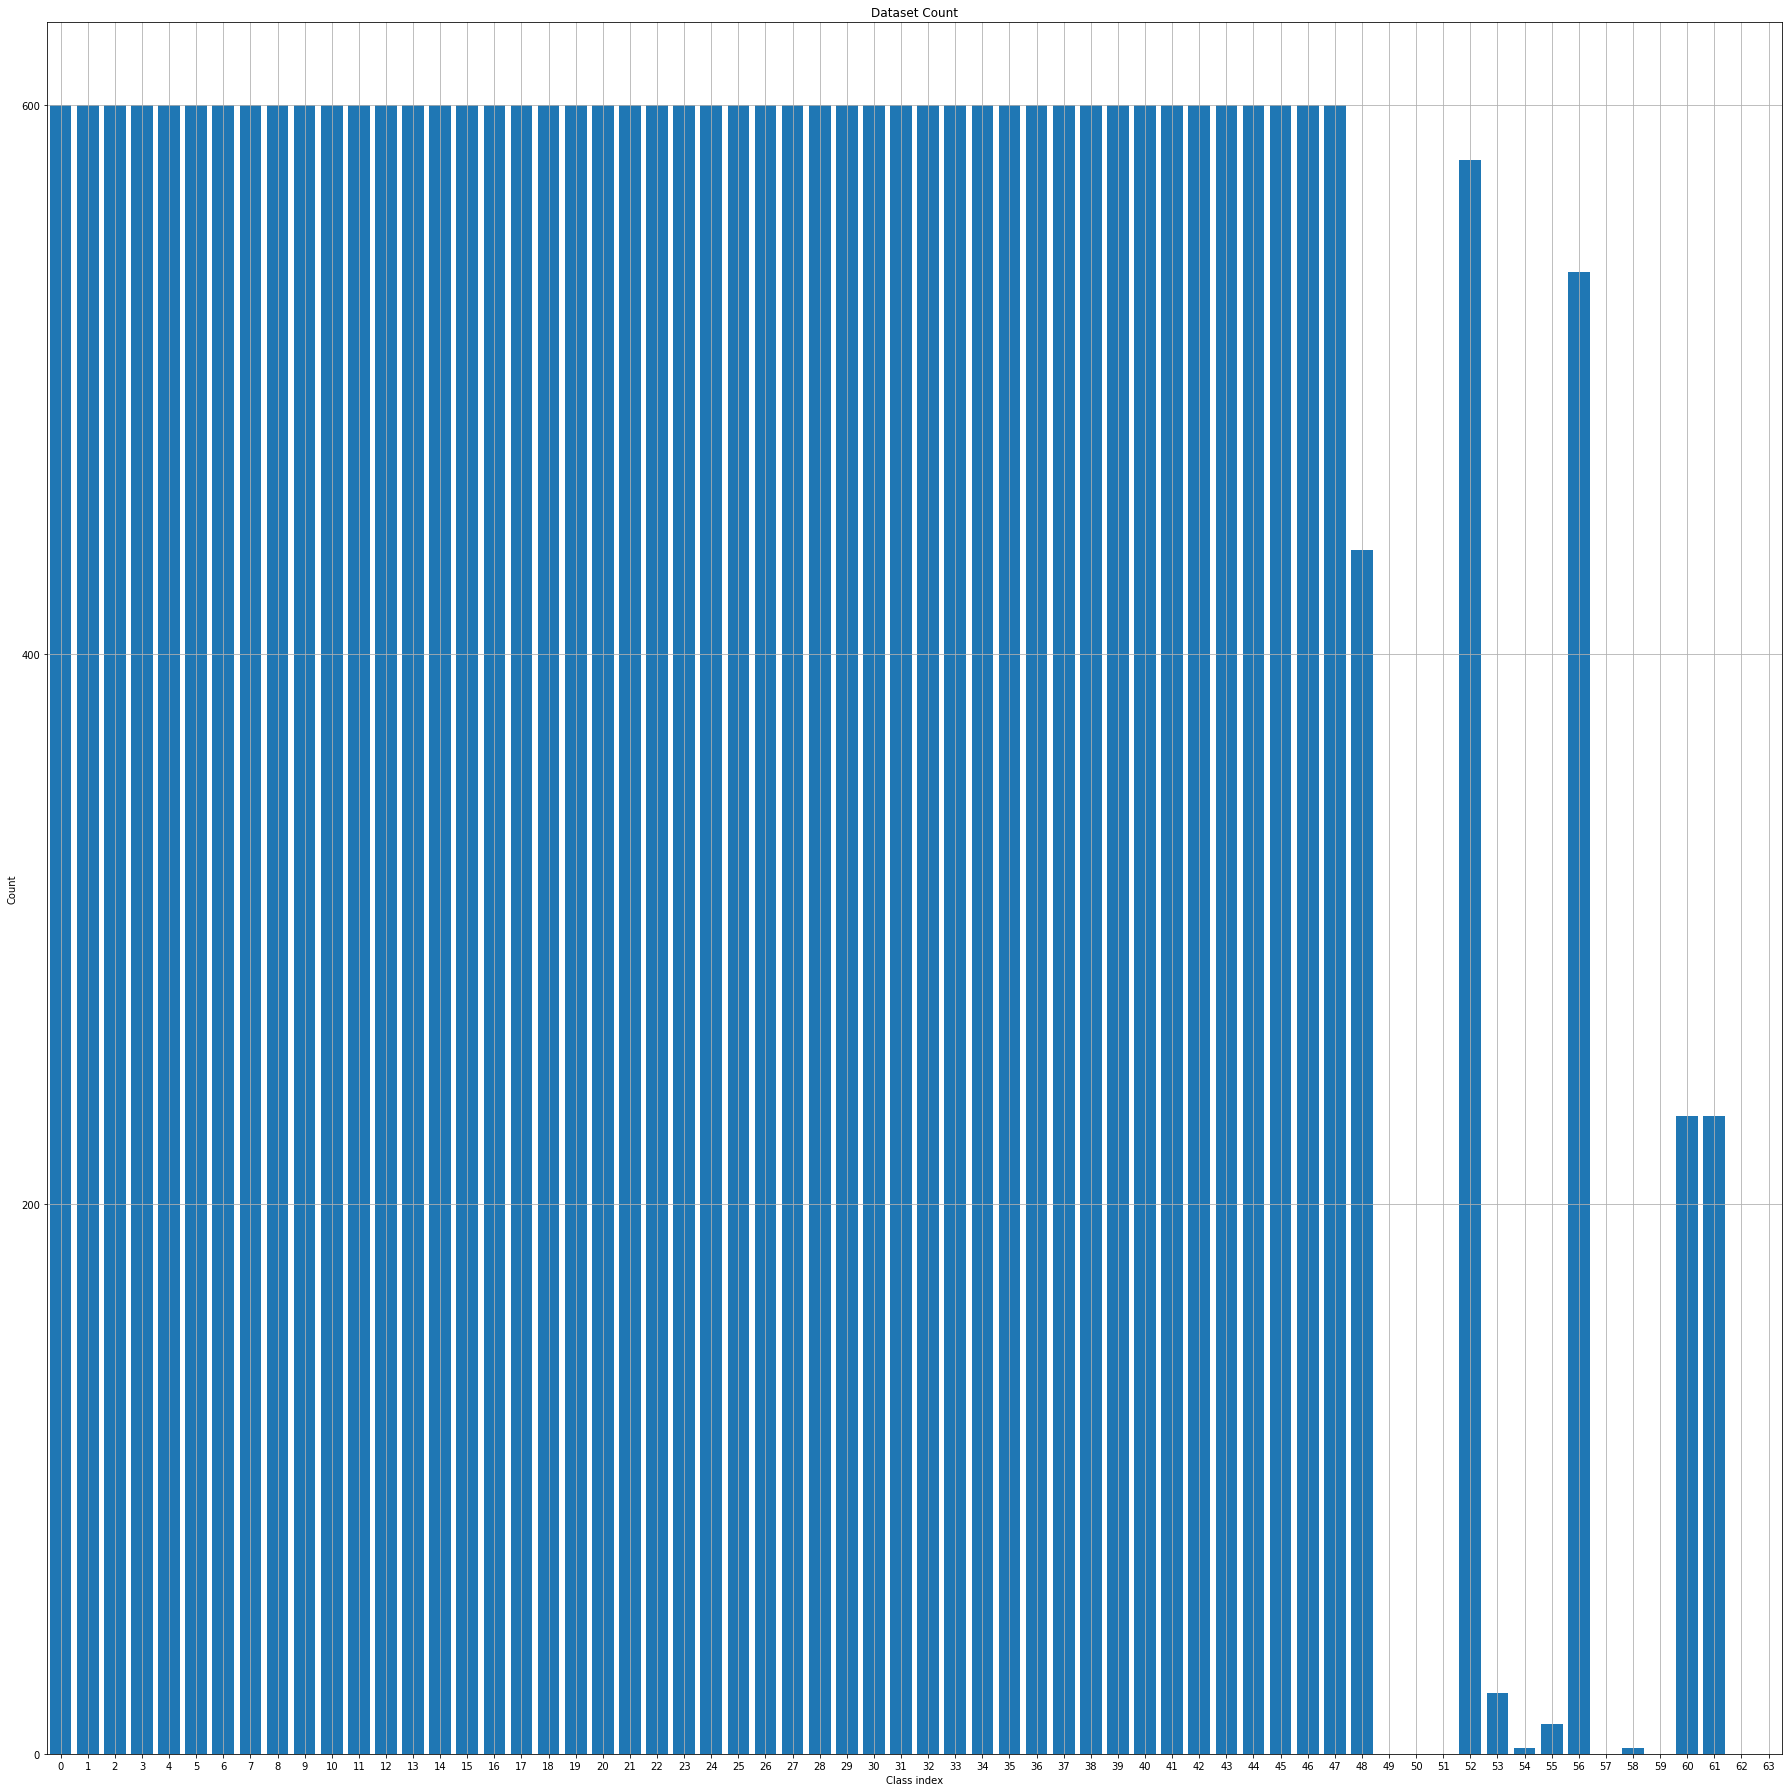

Main Epoch : 0/1
Train on 20806 samples, validate on 4458 samples
Epoch 1/1
20806/20806 [==============================] - 1608s - loss: 15.7894 - acc: 0.0172 - val_loss: 15.7818 - val_acc: 0.0209
Train on 9303 samples, validate on 1993 samples
Epoch 1/1
9303/9303 [==============================] - 635s - loss: 15.9726 - acc: 0.0090 - val_loss: 16.1181 - val_acc: 0.0000e+00
Data Control, Counting, & Training from Multiple Files done... Time Elapsed : -0.04532170295715332 seconds...
Data Control, Counting, & Training from Multiple Files done... Time Elapsed : 2272.132584095001 seconds...


In [12]:
start = time.time() # Begin time measurement

seed = 1000

training_obj = ComponentClassifierTraining(num_classes, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes,(100,100,1))

new_dataset_name = training_obj.control_dataset(dataset_PATH, dataset_name_list,num_classes,600)
data_count_list = training_obj.count_dataset(dataset_PATH, [new_dataset_name],num_classes) 

training_obj.train_from_multiple_files(1,seed,dataset_PATH,dataset_name_list,verbose = 1) ### Long procedure
weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29724+13291"
training_obj.save(dataset_PATH+weights_name)

trained_model = training_obj.model

end = time.time()#record time
time_cost_time_list = store_time(8,time_cost_time_list,end-start)
print_time_string(8,time_cost_string_list,time_cost_time_list)

# TestingClass

In [14]:
start = time.time() # Begin time measurement

seed = 1000

weights_name = new_dataset_name
#weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29739+7500(0-350)"
#weights_name = dataset_name
#dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_updated_29739"
#dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_updated_7500_0-350"
dataset_name_list = [new_dataset_name]

### Long procedure
testing_obj = TestingClass(dataset_PATH, wanted_w, wanted_h, export_w, export_h, max_piece_percent)
# Slower does testing with as little memory at all times as possible
ground_truth_list, prediction_list = testing_obj.test_classifier_multiple_slow(dataset_PATH, dataset_name_list,
                                     num_classes,dropout, 
                                     TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL,
                                     200,seed,350,706, weights_name = weights_name)

end = time.time()#record time
time_cost_time_list = store_time(9,time_cost_time_list,end-start)
print_time_string(9,time_cost_string_list,time_cost_time_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 29, 29, 64)        14464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 23, 23, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 256)       295168    
__________

OSError: Unable to open file (Unable to open file: name = 'c:/users/justinsanjuan/desktop/hkust/urop deep learning image-based structural analysis/code/python/testing folder/training_samples_64_classes_100x100_all_cleaned_32898.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

# Print Confusion Matrix

In [ ]:
start = time.time() # Begin time measurement

confusion_matrix_index = 1
from data_analysis_data import ground_truth_list_1 as ground_truth_list
from data_analysis_data import prediction_list_1 as prediction_list

#Add base data for confusion matrix
for i in range(64):
    ground_truth_list.append(i)
    prediction_list.append(i)
    
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ground_truth_list,prediction_list)

# Plot non-normalized confusion matrix
from helper_functions import plot_confusion_matrix
from constants import target_names_all
import matplotlib.pyplot as plt
plot_confusion_matrix(cnf_matrix, classes=target_names_all,
                      normalize=False,
                      title='Confusion matrix', 
                      cmap=plt.cm.Blues,PATH=dataset_PATH, name="confusion_matrix_"+str(confusion_matrix_index), verbose = False)

from helper_functions import confusion_matrix_analysis
dataset_PATH = "C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/"
name = "confusion_matrix_"+str(confusion_matrix_index)+"_analysis"
min_count = 5
confusion_matrix_analysis(cnf_matrix, dataset_PATH, name, min_count, verbose = False) #Turn verbose on to show data analysis

end = time.time()#record time
time_cost_time_list = store_time(10,time_cost_time_list,end-start)
print_time_string(10,time_cost_string_list,time_cost_time_list)

# Time Cost Analysis

In [ ]:
time_cost_string = ''
for i in range(len(time_cost_string_list)):
    time_cost_string += time_cost_string_list[i] +' : ' + time_cost_time_list[i]+'\n'
print(time_cost_string)